<div style="background: linear-gradient(to right,rgb(225, 231, 134),rgb(176, 238, 148),rgb(150, 232, 238)); padding: 20px; border-radius: 10px; text-align: center; box-shadow: 0 10px 20px rgba(0,0,0,0.19), 0 6px 6px rgba(0,0,0,0.23);">
    <span style="font-family: 'Montserrat', sans-serif; font-weight: 800; font-size: 2.5em; color: white; text-shadow: 2px 2px 4px #000;">✨ IMPORTS ✨</span>
</div>

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import precision_score, recall_score, f1_score, balanced_accuracy_score
import pickle
from collections import defaultdict
from sklearn.utils import shuffle
import os
import cv2
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import pandas as pd

from torchinfo import summary
from sklearn.metrics import confusion_matrix
import seaborn as sns



<div style="background: linear-gradient(to right,rgb(225, 231, 134),rgb(176, 238, 148),rgb(150, 232, 238)); padding: 20px; border-radius: 10px; text-align: center; box-shadow: 0 10px 20px rgba(0,0,0,0.19), 0 6px 6px rgba(0,0,0,0.23);">
    <span style="font-family: 'Montserrat', sans-serif; font-weight: 800; font-size: 2.5em; color: white; text-shadow: 2px 2px 4px #000;">✨ LOADING THE SPLIT DATA ARRAYS ✨</span>
</div>

<div style="background: linear-gradient(to right,rgb(225, 231, 134),rgb(176, 238, 148),rgb(150, 232, 238)); padding: 15px; border-radius: 8px; text-align: center; box-shadow: 0 8px 16px rgba(0,0,0,0.19), 0 4px 4px rgba(0,0,0,0.23);">
    <span style="font-family: 'Montserrat', sans-serif; font-weight: 700; font-size: 1.2em; color: white; text-shadow: 1px 1px 3px #000;">📁 reminder to change the folder path to your numpy array folder 📁</span>
</div>

In [6]:
import numpy as np
import os

# Define the folder path
folder_path = r"D:\PYTHONIG\aprilmay2025\data\numpy\melunfiltered\concatenatedspectrograms"

# Load the numpy files into the respective arrays with the correct capitalized naming
eeg_fold_1 = np.load(os.path.join(folder_path, 'MEL_DATA_FOLD_fold_1.npy'))
labels_fold_1 = np.load(os.path.join(folder_path, 'MEL_LABELS_FOLD_fold_1.npy'))
patients_fold_1 = np.load(os.path.join(folder_path, 'MEL_PATIENTS_FOLD_fold_1.npy'))

eeg_fold_2 = np.load(os.path.join(folder_path, 'MEL_DATA_FOLD_fold_2.npy'))
labels_fold_2 = np.load(os.path.join(folder_path, 'MEL_LABELS_FOLD_fold_2.npy'))
patients_fold_2 = np.load(os.path.join(folder_path, 'MEL_PATIENTS_FOLD_fold_2.npy'))

eeg_fold_3 = np.load(os.path.join(folder_path, 'MEL_DATA_FOLD_fold_3.npy'))
labels_fold_3 = np.load(os.path.join(folder_path, 'MEL_LABELS_FOLD_fold_3.npy'))
patients_fold_3 = np.load(os.path.join(folder_path, 'MEL_PATIENTS_FOLD_fold_3.npy'))

eeg_fold_4 = np.load(os.path.join(folder_path, 'MEL_DATA_FOLD_fold_4.npy'))
labels_fold_4 = np.load(os.path.join(folder_path, 'MEL_LABELS_FOLD_fold_4.npy'))
patients_fold_4 = np.load(os.path.join(folder_path, 'MEL_PATIENTS_FOLD_fold_4.npy'))

eeg_fold_5 = np.load(os.path.join(folder_path, 'MEL_DATA_FOLD_fold_5.npy'))
labels_fold_5 = np.load(os.path.join(folder_path, 'MEL_LABELS_FOLD_fold_5.npy'))
patients_fold_5 = np.load(os.path.join(folder_path, 'MEL_PATIENTS_FOLD_fold_5.npy'))

eeg_folds = [eeg_fold_1, eeg_fold_2, eeg_fold_3, eeg_fold_4, eeg_fold_5]
labels_folds = [labels_fold_1, labels_fold_2, labels_fold_3, labels_fold_4, labels_fold_5]
patients_folds = [patients_fold_1, patients_fold_2, patients_fold_3, patients_fold_4, patients_fold_5]

for i in range(len(eeg_folds)):
    eeg_folds[i] = eeg_folds[i].astype(np.float16)

In [7]:
eeg_fold_1.shape

(1297, 224, 224, 3)

<div style="background: linear-gradient(to right,rgb(225, 231, 134),rgb(176, 238, 148),rgb(150, 232, 238)); padding: 15px; border-radius: 8px; text-align: center; box-shadow: 0 8px 16px rgba(0,0,0,0.19), 0 4px 4px rgba(0,0,0,0.23);">
    <span style="font-family: 'Montserrat', sans-serif; font-weight: 700; font-size: 1.2em; color: white; text-shadow: 1px 1px 3px #000;">data balancer & early stopping</span>
</div>

In [8]:
def data_balancer(data, labels, factor):
    # Count the number of samples in each class
    num_class_0 = np.sum(labels == 0)
    num_class_1 = np.sum(labels == 1)
    num_class_2 = np.sum(labels == 2)

    # Find the minimum number of samples across all classes
    min_samples = min(num_class_0, num_class_1, num_class_2)

    # Calculate the number of samples to take from each class
    samples_per_class = min_samples // factor

    # Randomly sample 'samples_per_class' from each class
    class_0_indices = np.random.choice(np.where(labels == 0)[0], samples_per_class, replace=False)
    class_1_indices = np.random.choice(np.where(labels == 1)[0], samples_per_class, replace=False)
    class_2_indices = np.random.choice(np.where(labels == 2)[0], samples_per_class, replace=False)

    # Combine balanced indices
    balanced_indices = np.concatenate((class_0_indices, class_1_indices, class_2_indices))

    # Shuffle the balanced indices
    np.random.shuffle(balanced_indices)

    # Create balanced training data and labels
    balanced_data = data[balanced_indices]
    balanced_labels = labels[balanced_indices]

    return balanced_data, balanced_labels

In [9]:
class EarlyStopping:
    def __init__(self, patience=5):
        """
        Initializes the early stopping mechanism based on divergence detection.

        Args:
            patience (int): Number of consecutive epochs with increasing validation loss
                            before stopping.
        """
        self.patience = patience
        self.best_loss = None
        self.counter = 0
        self.early_stop = False
        self.best_model_state = None

    def __call__(self, val_loss, model):
        """
        Checks if the validation loss is diverging and updates the state accordingly.

        Args:
            val_loss (float): Current epoch's validation loss.
            model (torch.nn.Module): The model being trained.
        """
        if self.best_loss is None or val_loss < self.best_loss:
            # Improvement detected
            self.best_loss = val_loss
            self.best_model_state = model.state_dict()
            self.counter = 0
        else:
            # Validation loss increased
            self.counter += 1
            if self.counter >= self.patience:
                print(f"Divergence detected. Stopping training after {self.counter} epochs.")
                self.early_stop = True

    def load_best_model(self, model):
        """
        Restores the model to the state with the lowest validation loss.

        Args:
            model (torch.nn.Module): The model to restore.
        """
        model.load_state_dict(self.best_model_state)




<div style="background: linear-gradient(to right,rgb(225, 231, 134),rgb(176, 238, 148),rgb(150, 232, 238)); padding: 15px; border-radius: 8px; text-align: center; box-shadow: 0 8px 16px rgba(0,0,0,0.19), 0 4px 4px rgba(0,0,0,0.23);">
    <span style="font-family: 'Montserrat', sans-serif; font-weight: 700; font-size: 1.2em; color: white; text-shadow: 1px 1px 3px #000;">Result plotting</span>
</div>

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    precision_recall_curve,
    roc_curve,
    auc,
    f1_score,
    balanced_accuracy_score,
    classification_report,
)
from sklearn.preprocessing import label_binarize

def plot_metrics(labels, predictions, n_classes=3):
    """
    Plots and computes metrics for classification tasks.

    Args:
        labels (array-like): True labels.
        predictions (array-like): Predicted probabilities or class predictions.
        n_classes (int): Number of classes (default is 3 for multi-class classification).
    """
    # If predictions are probabilities, convert to class predictions
    if predictions.ndim > 1:
        predicted_classes = np.argmax(predictions, axis=1)
    else:
        predicted_classes = predictions

    # Confusion Matrix
    cm = confusion_matrix(labels, predicted_classes)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    # Class-wise Accuracy
    print("\nClass-wise Accuracy:")
    for d in range(n_classes):
        correct_preds = cm[d][d]
        total_true_samples = sum(cm[d])
        ratio_correct = correct_preds / total_true_samples if total_true_samples != 0 else 0
        print(f'Class {d}: Correct Predictions / Total True Samples = {correct_preds}/{total_true_samples} ({ratio_correct:.2%})')

    # Precision-Recall Curves and AUPRC
    print("\nPrecision-Recall Curves:")
    labels_binarized = label_binarize(labels, classes=np.arange(n_classes))
    auprcs = []
    for class_idx in range(n_classes):
        precision, recall, _ = precision_recall_curve(labels_binarized[:, class_idx], predictions[:, class_idx])
        auprc = auc(recall, precision)
        auprcs.append(auprc)
        plt.plot(recall, precision, label=f'Class {class_idx + 1} (AUPRC = {auprc:.2f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curves for each class')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

    # ROC Curves and AUC
    print("\nROC Curves:")
    for class_idx in range(n_classes):
        fpr, tpr, _ = roc_curve(labels_binarized[:, class_idx], predictions[:, class_idx])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {class_idx + 1} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for each class')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

    # Mean F1 Score
    f1 = f1_score(labels, predicted_classes, average='macro')
    print(f"\nMean F1 Score: {f1:.4f}")

    # Balanced Accuracy
    balanced_acc = balanced_accuracy_score(labels, predicted_classes)
    print(f"Balanced Accuracy: {balanced_acc:.4f}")

    # Average AUPRC
    mean_auprc = np.mean(auprcs)
    print(f"Average AUPRC: {mean_auprc:.4f}")

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(labels, predicted_classes))

    return {
        "confusion_matrix": cm,
        "class_wise_accuracy": [cm[d][d] / sum(cm[d]) if sum(cm[d]) != 0 else 0 for d in range(n_classes)],
        "mean_f1_score": f1,
        "balanced_accuracy": balanced_acc,
        "average_auprc": mean_auprc,
        "auprc_per_class": auprcs,
    }

<div style="background: linear-gradient(to right,rgb(225, 231, 134),rgb(238, 206, 148),rgb(238, 150, 150)); padding: 15px; border-radius: 8px; text-align: center; box-shadow: 0 8px 16px rgba(0,0,0,0.19), 0 4px 4px rgba(0,0,0,0.23);">
    <span style="font-family: 'Montserrat', sans-serif; font-weight: 700; font-size: 1.2em; color: white; text-shadow: 1px 1px 3px #000;">MODEL GOES HERE</span>
</div>

In [11]:
debug_mode_flag = False
import torch
import torch.nn as nn

class CustomCnn(nn.Module):
    def __init__(self, debug_mode_flag=False):
        super().__init__()
        self.debug_mode_flag = debug_mode_flag
        
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Reduces spatial size
        )
        
        self.block_2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Further reduces spatial size
        )

        # Global Average Pooling to reduce spatial dimensions 
        self.global_avg_pool = nn.AdaptiveAvgPool2d((8, 8))  # Keeps a manageable seq_len
        self.flatten = nn.Flatten(start_dim=2)  # Keeps batch & channel dims

    def forward(self, x):
        if self.debug_mode_flag: print(f"Input shape: {x.shape}")
        
        x = self.block_1(x)
        if self.debug_mode_flag: print(f"Block 1 shape: {x.shape}")
        
        x = self.block_2(x)
        if self.debug_mode_flag: print(f"Block 2 shape: {x.shape}")
        
        x = self.global_avg_pool(x)  # (batch, 128, 8, 8)
        if self.debug_mode_flag: print(f"Global Avg Pool shape: {x.shape}")

        # x = self.flatten(x)  # (batch, 128, 64)
        # if self.debug_mode_flag: print(f"Flattened shape (Transformer Input): {x.shape}")
        
        return x

    
class TransformerEncoder(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout_rate=0.1):
        super(TransformerEncoder, self).__init__()
        self.att = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads)
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, embed_dim)
        )
        self.layernorm1 = nn.LayerNorm(embed_dim)
        self.layernorm2 = nn.LayerNorm(embed_dim)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.dropout2 = nn.Dropout(dropout_rate)

    def forward(self, x):
        attn_output, _ = self.att(x, x, x)
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(x + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)
    
class TRANS_CNN(nn.Module):
    def __init__(self, input_shape, num_classes, embed_dim=512, num_heads=2, ff_dim=64, num_transformer_blocks=4):
        
        super(TRANS_CNN,self).__init__()
        
        self.num_transformer_blocks = num_transformer_blocks
        self.cnn_extractor = CustomCnn()
        
        self.projection = nn.Linear(512, embed_dim)
        
        self.encoder = nn.ModuleList([
            TransformerEncoder(embed_dim,num_heads,ff_dim) for _ in range(num_transformer_blocks)
        ])
        
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        self.dropout = nn.Dropout(0.1)
        
        self.precls = nn.Linear(embed_dim,embed_dim)
        self.precls2 = nn.Linear(embed_dim,embed_dim)
        self.precls3 = nn.Linear(embed_dim,embed_dim//4)
        
        self.clf = nn.Linear(embed_dim//4,num_classes)
        
        
    def forward(self,x):
        
        x = self.cnn_extractor(x)
        if debug_mode_flag: print(f"x shape after cnn extraction = {x.shape}")
        
        B,C,H,W = x.shape
        
        x = x.view(B,H*W,C)
        if debug_mode_flag: print(f"x shape after changing view= {x.shape}")
        
        # x = self.projection(x)
        # if debug_mode_flag: print(f"x shape after projection= {x.shape}")
        
        for encoderblock in self.encoder:
            x = encoderblock(x)
            
        if debug_mode_flag: print(f"x shape after passing thru encoder= {x.shape}")
        
        x = x.permute(1,0,2)
        if debug_mode_flag: print(f"x shape after permuting{x.shape}")
        
        x = self.precls3(x)
        if debug_mode_flag: print(f"precls3 {x.shape}")
        
        x = self.dropout(x)
        
        x = x.mean(dim=0)  # Global average pooling over sequence (9 tokens → 1 token)
        if debug_mode_flag: print(f"x shape after average pooling {x.shape}")

        x = self.clf(x)  #they see me rolling
        if debug_mode_flag: print(f"cls {x.shape}")
        
        
        return x

<div style="background: linear-gradient(to right,rgb(225, 231, 134),rgb(238, 206, 148),rgb(238, 150, 150)); padding: 15px; border-radius: 8px; text-align: center; box-shadow: 0 8px 16px rgba(0,0,0,0.19), 0 4px 4px rgba(0,0,0,0.23);">
    <span style="font-family: 'Montserrat', sans-serif; font-weight: 700; font-size: 1.2em; color: white; text-shadow: 1px 1px 3px #000;">Test with demo data & model Summary</span>
</div>

In [12]:
model  = TRANS_CNN(input_shape=(224,224,3),num_classes=3,num_transformer_blocks=4,embed_dim=128) # declare model here
randomdata = torch.randn((1,3,224,224))
output = model(randomdata)
output.shape

torch.Size([1, 3])

In [13]:
from torchinfo import summary

summary(model)

Layer (type:depth-idx)                                       Param #
TRANS_CNN                                                    --
├─CustomCnn: 1-1                                             --
│    └─Sequential: 2-1                                       --
│    │    └─Conv2d: 3-1                                      448
│    │    └─BatchNorm2d: 3-2                                 32
│    │    └─ReLU: 3-3                                        --
│    │    └─Conv2d: 3-4                                      4,640
│    │    └─BatchNorm2d: 3-5                                 64
│    │    └─ReLU: 3-6                                        --
│    │    └─MaxPool2d: 3-7                                   --
│    └─Sequential: 2-2                                       --
│    │    └─Conv2d: 3-8                                      18,496
│    │    └─BatchNorm2d: 3-9                                 128
│    │    └─ReLU: 3-10                                       --
│    │    └─Conv2d: 3-11  

<div style="background: linear-gradient(to right,rgb(225, 231, 134),rgb(238, 206, 148),rgb(238, 150, 150)); padding: 15px; border-radius: 8px; text-align: center; box-shadow: 0 8px 16px rgba(0,0,0,0.19), 0 4px 4px rgba(0,0,0,0.23);">
    <span style="font-family: 'Montserrat', sans-serif; font-weight: 700; font-size: 1.2em; color: white; text-shadow: 1px 1px 3px #000;">Training Code</span>
</div>

In [18]:

import pandas as pd
import os
import datetime


torch.random.manual_seed(42)  # For reproducibility
np.random.seed(42)  # For reproducibility

params = {'num_heads': 8, 'num_transformer_blocks': 8, 'learning_rate': 7.32e-05, 'optimizer': 'Adam', 'weight_decay': 3.94e-05, 'batch_size': 10, 'factor': 1}


# Fold indices and other configurations
num_folds = 5
fold_indices = np.random.permutation(np.arange(num_folds))
val_fold_indices = np.roll(fold_indices, 1)

test_folds_chosen = []
val_folds_chosen = []
fold_confusion_matrices = []  # To store confusion matrices for each fold
fold_accuracies = []  # To store balanced accuracy for each fold
fold_auprcs = []  # To store AUPRC for each fold

# Model and training configurations
num_classes = 3
epochs = 100
input_shape = (3,224,224)
embed_dim = 128
num_heads = params['num_heads']
num_transformer_blocks = params['num_transformer_blocks']
learning_rate = params['learning_rate']
optimizer = params['optimizer']
weight_decay = params['weight_decay']
batch_size = params['batch_size']

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



In [19]:
def save_results_to_csv(fold_accuracies, fold_auprcs, fold_confusion_matrices, model_info, csv_path=r"D:\PYTHONIG\aprilmay2025\newnotebooks\results.csv"):
    """
    Save all results from the current experiment to a CSV file
    
    Parameters:
    - fold_accuracies: list of balanced accuracy scores for each fold
    - fold_auprcs: list of AUPRC scores for each fold
    - fold_confusion_matrices: list of confusion matrices for each fold
    - model_info: string with model architecture description
    - csv_path: path to the CSV file to save results
    """
    # Current time for experiment identification
    timestamp = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    
    # Prepare data for the DataFrame
    data = {
        "timestamp": timestamp,
        "model_info": model_info,
        "num_classes": num_classes,
        "learning_rate": learning_rate,
        "epochs": epochs,
        "mean_balanced_accuracy": np.mean(fold_accuracies),
        "std_balanced_accuracy": np.std(fold_accuracies),
        "mean_auprc": np.mean(fold_auprcs),
        "std_auprc": np.std(fold_auprcs),
    }
    
    # Add individual fold results
    for i, (acc, auprc) in enumerate(zip(fold_accuracies, fold_auprcs)):
        data[f"fold_{i+1}_accuracy"] = acc
        data[f"fold_{i+1}_auprc"] = auprc
    
    # Add confusion matrix info
    for i, cm in enumerate(fold_confusion_matrices):
        data[f"fold_{i+1}_confusion_matrix"] = str(cm)
    
    # Create DataFrame and append to CSV
    df = pd.DataFrame([data])
    
    # Check if file exists
    file_exists = os.path.isfile(csv_path)
    
    # Save to CSV
    if file_exists:
        df.to_csv(csv_path, mode='a', header=False, index=False)
    else:
        df.to_csv(csv_path, mode='w', header=True, index=False)
    
    print(f"Results saved to {csv_path}")

Fold No: 1
training on folds: [[np.int64(4), np.int64(2), np.int64(0)]]
validation on folds: 3
test on folds: 1
Epoch [1/100], Loss: 1.0926, Accuracy: 0.3982
Validation Loss: 1.1216, Validation Accuracy: 0.3762
Epoch [2/100], Loss: 1.0274, Accuracy: 0.5195
Validation Loss: 1.0138, Validation Accuracy: 0.4675
Epoch [3/100], Loss: 0.9877, Accuracy: 0.6002
Validation Loss: 1.0503, Validation Accuracy: 0.4726
Epoch [4/100], Loss: 0.9762, Accuracy: 0.6417
Validation Loss: 1.0310, Validation Accuracy: 0.4813
Epoch [5/100], Loss: 0.9678, Accuracy: 0.6459
Validation Loss: 0.9839, Validation Accuracy: 0.4979
Epoch [6/100], Loss: 0.9551, Accuracy: 0.6500
Validation Loss: 0.9785, Validation Accuracy: 0.4861
Epoch [7/100], Loss: 0.9512, Accuracy: 0.6575
Validation Loss: 0.9903, Validation Accuracy: 0.4876
Epoch [8/100], Loss: 0.9296, Accuracy: 0.7016
Validation Loss: 1.0014, Validation Accuracy: 0.5097
Epoch [9/100], Loss: 0.9269, Accuracy: 0.6958
Validation Loss: 0.9653, Validation Accuracy: 0.50

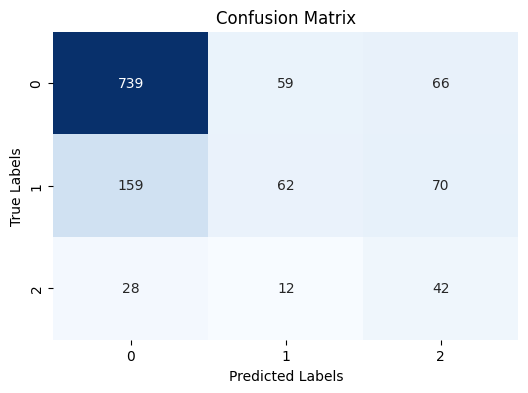


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 739/864 (85.53%)
Class 1: Correct Predictions / Total True Samples = 62/291 (21.31%)
Class 2: Correct Predictions / Total True Samples = 42/82 (51.22%)

Precision-Recall Curves:


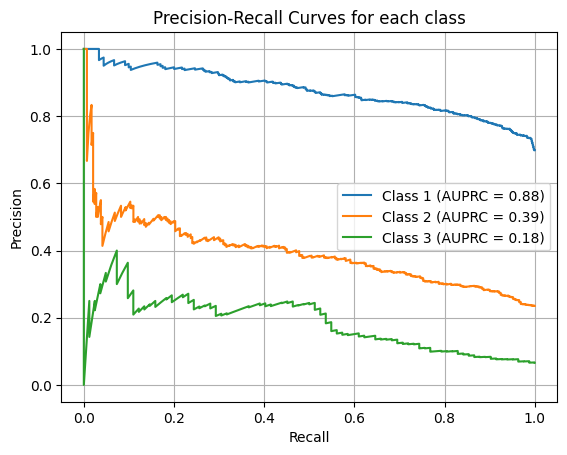


ROC Curves:


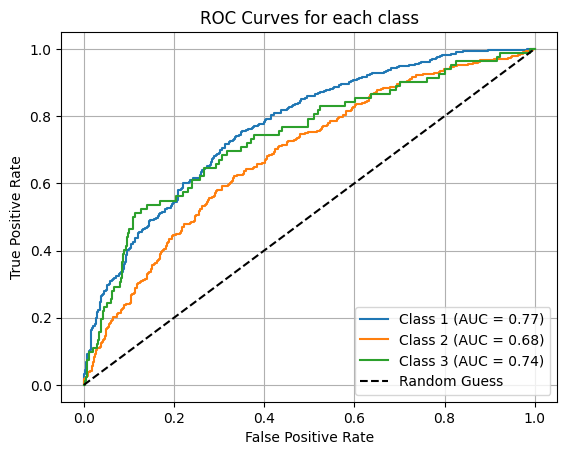


Mean F1 Score: 0.4804
Balanced Accuracy: 0.5269
Average AUPRC: 0.4834

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.86      0.83       864
           1       0.47      0.21      0.29       291
           2       0.24      0.51      0.32        82

    accuracy                           0.68      1237
   macro avg       0.50      0.53      0.48      1237
weighted avg       0.68      0.68      0.67      1237

Fold No: 2
training on folds: [[np.int64(2), np.int64(0), np.int64(3)]]
validation on folds: 1
test on folds: 4
Epoch [1/100], Loss: 1.1014, Accuracy: 0.3605
Validation Loss: 1.2729, Validation Accuracy: 0.3852
Epoch [2/100], Loss: 1.0370, Accuracy: 0.5051
Validation Loss: 1.1057, Validation Accuracy: 0.5443
Epoch [3/100], Loss: 1.0052, Accuracy: 0.5527
Validation Loss: 1.0298, Validation Accuracy: 0.5852
Epoch [4/100], Loss: 0.9951, Accuracy: 0.5842
Validation Loss: 1.0413, Validation Accuracy: 0.5470
Epoch [5/100], L

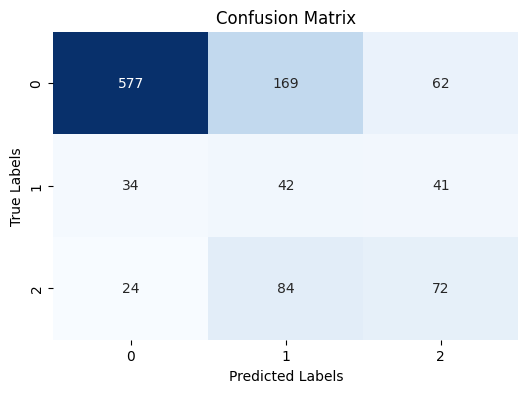


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 577/808 (71.41%)
Class 1: Correct Predictions / Total True Samples = 42/117 (35.90%)
Class 2: Correct Predictions / Total True Samples = 72/180 (40.00%)

Precision-Recall Curves:


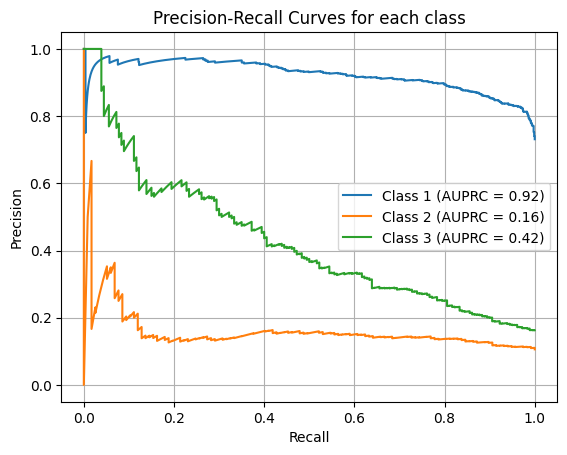


ROC Curves:


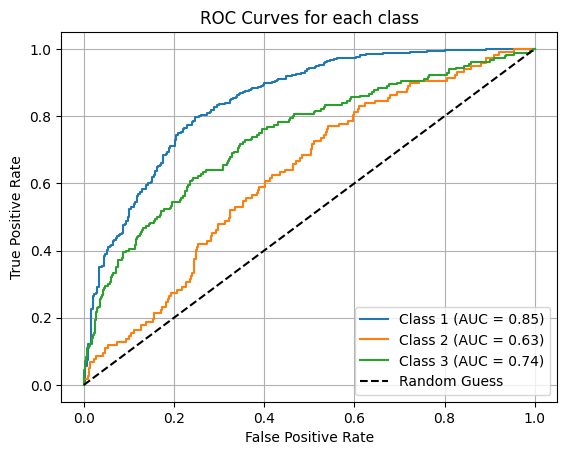


Mean F1 Score: 0.4697
Balanced Accuracy: 0.4910
Average AUPRC: 0.5017

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.71      0.80       808
           1       0.14      0.36      0.20       117
           2       0.41      0.40      0.41       180

    accuracy                           0.63      1105
   macro avg       0.49      0.49      0.47      1105
weighted avg       0.75      0.63      0.67      1105

Fold No: 3
training on folds: [[np.int64(1), np.int64(0), np.int64(3)]]
validation on folds: 4
test on folds: 2
Epoch [1/100], Loss: 1.1059, Accuracy: 0.3474
Validation Loss: 1.0621, Validation Accuracy: 0.4719
Epoch [2/100], Loss: 1.0516, Accuracy: 0.4885
Validation Loss: 0.9951, Validation Accuracy: 0.4857
Epoch [3/100], Loss: 1.0065, Accuracy: 0.5714
Validation Loss: 0.9556, Validation Accuracy: 0.5121
Epoch [4/100], Loss: 0.9889, Accuracy: 0.5970
Validation Loss: 0.9737, Validation Accuracy: 0.5094
Epoch [5/100], L

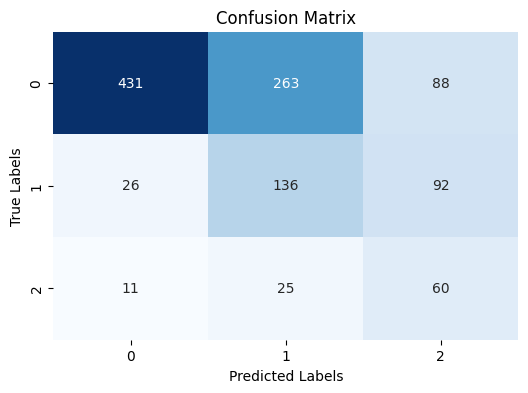


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 431/782 (55.12%)
Class 1: Correct Predictions / Total True Samples = 136/254 (53.54%)
Class 2: Correct Predictions / Total True Samples = 60/96 (62.50%)

Precision-Recall Curves:


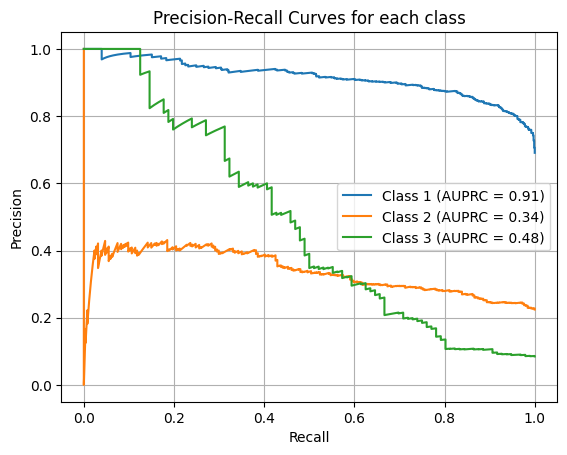


ROC Curves:


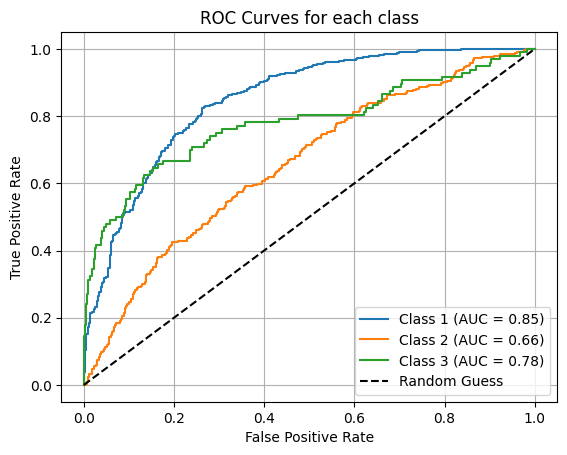


Mean F1 Score: 0.4826
Balanced Accuracy: 0.5705
Average AUPRC: 0.5755

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.55      0.69       782
           1       0.32      0.54      0.40       254
           2       0.25      0.62      0.36        96

    accuracy                           0.55      1132
   macro avg       0.50      0.57      0.48      1132
weighted avg       0.73      0.55      0.60      1132

Fold No: 4
training on folds: [[np.int64(1), np.int64(4), np.int64(3)]]
validation on folds: 2
test on folds: 0
Epoch [1/100], Loss: 1.1048, Accuracy: 0.3595
Validation Loss: 1.1027, Validation Accuracy: 0.4065
Epoch [2/100], Loss: 1.0500, Accuracy: 0.5012
Validation Loss: 0.9988, Validation Accuracy: 0.4781
Epoch [3/100], Loss: 0.9951, Accuracy: 0.6082
Validation Loss: 1.0365, Validation Accuracy: 0.5045
Epoch [4/100], Loss: 0.9681, Accuracy: 0.6228
Validation Loss: 1.0754, Validation Accuracy: 0.5101
Epoch [5/100], L

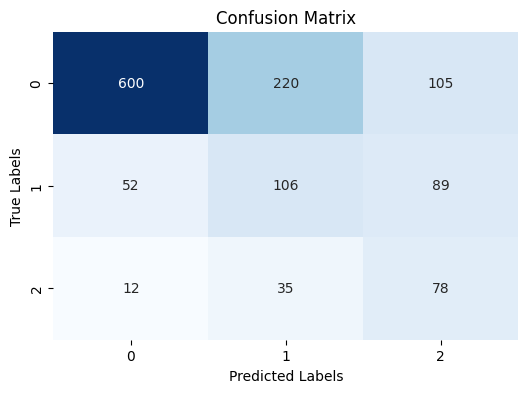


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 600/925 (64.86%)
Class 1: Correct Predictions / Total True Samples = 106/247 (42.91%)
Class 2: Correct Predictions / Total True Samples = 78/125 (62.40%)

Precision-Recall Curves:


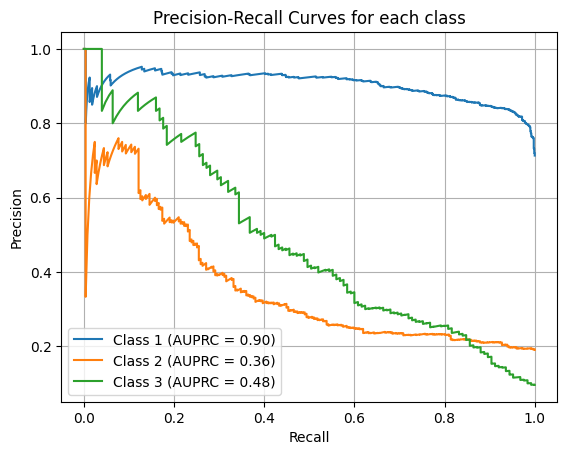


ROC Curves:


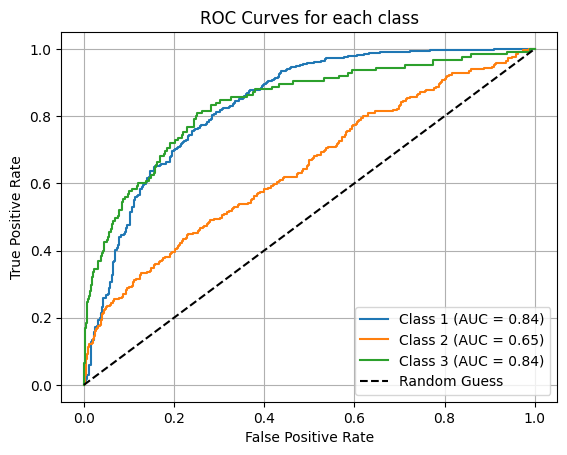


Mean F1 Score: 0.4989
Balanced Accuracy: 0.5673
Average AUPRC: 0.5805

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.65      0.76       925
           1       0.29      0.43      0.35       247
           2       0.29      0.62      0.39       125

    accuracy                           0.60      1297
   macro avg       0.49      0.57      0.50      1297
weighted avg       0.73      0.60      0.64      1297

Fold No: 5
training on folds: [[np.int64(1), np.int64(4), np.int64(2)]]
validation on folds: 0
test on folds: 3
Epoch [1/100], Loss: 1.0998, Accuracy: 0.3669
Validation Loss: 1.1134, Validation Accuracy: 0.3647
Epoch [2/100], Loss: 1.0554, Accuracy: 0.4693
Validation Loss: 0.9942, Validation Accuracy: 0.5338
Epoch [3/100], Loss: 1.0114, Accuracy: 0.5689
Validation Loss: 0.9962, Validation Accuracy: 0.5456
Epoch [4/100], Loss: 0.9800, Accuracy: 0.6220
Validation Loss: 1.0194, Validation Accuracy: 0.5464
Epoch [5/100], L

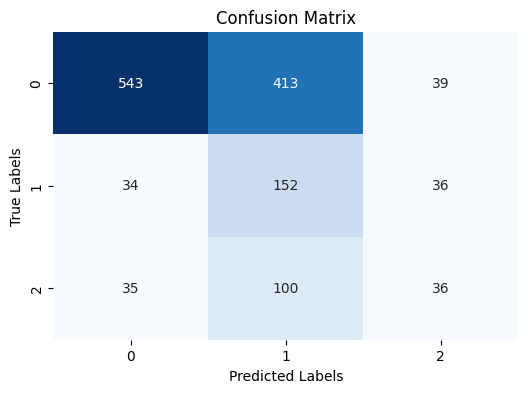


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 543/995 (54.57%)
Class 1: Correct Predictions / Total True Samples = 152/222 (68.47%)
Class 2: Correct Predictions / Total True Samples = 36/171 (21.05%)

Precision-Recall Curves:


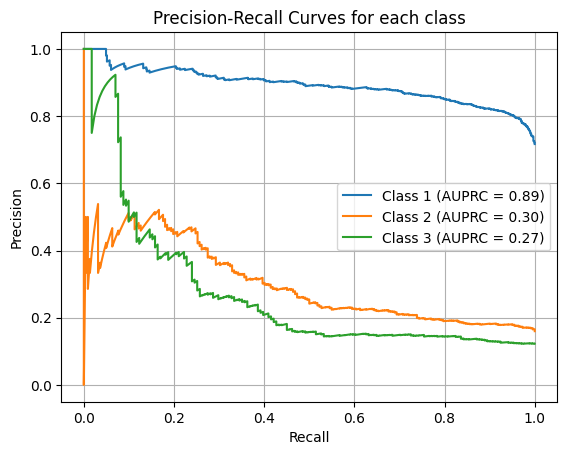


ROC Curves:


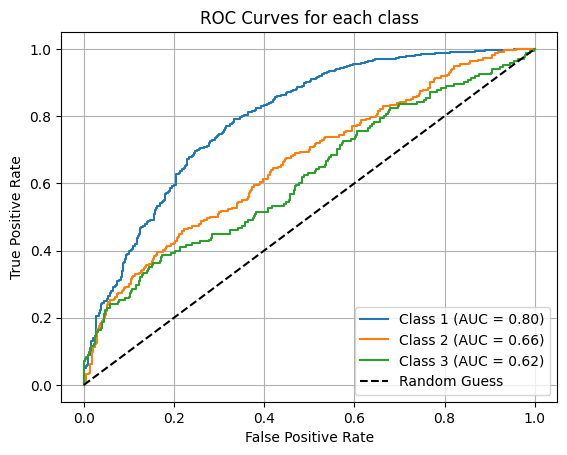


Mean F1 Score: 0.4246
Balanced Accuracy: 0.4803
Average AUPRC: 0.4861

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.55      0.68       995
           1       0.23      0.68      0.34       222
           2       0.32      0.21      0.26       171

    accuracy                           0.53      1388
   macro avg       0.48      0.48      0.42      1388
weighted avg       0.71      0.53      0.57      1388

Accuracy for each fold: [np.float64(0.5268592050897599), np.float64(0.491027756621816), np.float64(0.5705279886689355), np.float64(0.5672661487398329), np.float64(0.48031321456341297)]
AUPRC for each fold: [np.float64(0.4833652737831969), np.float64(0.5016581398913491), np.float64(0.5754840785663539), np.float64(0.5805161873205488), np.float64(0.4861476433646246)]
Average AUPRC across all folds: 0.5254342645852146
Average Balanced Accuracy across all folds: 0.5271988627367514


In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import balanced_accuracy_score, confusion_matrix
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve, auc




# Training loop for cross-validation
for fold_idx in range(num_folds):
    print(f'Fold No: {fold_idx + 1}')
    
    # Initialize model, loss, and optimizer
    fold_model = TRANS_CNN(input_shape=input_shape,num_classes=num_classes,embed_dim=128,num_heads=num_heads,num_transformer_blocks=num_transformer_blocks) # Initialize your model here
    fold_model.to(device)
    
    criterion = nn.CrossEntropyLoss(label_smoothing=0.3)
    optimizer = optim.AdamW(fold_model.parameters(), lr=learning_rate,weight_decay=weight_decay)
    
    # Split data into train, validation, and test sets
    test_fold = fold_indices[fold_idx]
    val_fold = val_fold_indices[fold_idx]
    train_folds = [fold for fold in fold_indices if fold != test_fold and fold != val_fold]
    
    print(f"training on folds: {[train_folds]}")
    print(f"validation on folds: {val_fold}")
    print(f"test on folds: {test_fold}")
    

    train_data = np.concatenate([eeg_folds[j] for j in train_folds])
    train_labels = np.concatenate([labels_folds[j] for j in train_folds])
    train_data = train_data.transpose(0, 3, 1, 2)  # Transpose to match PyTorch input format

    test_folds_chosen.append(test_fold)
    val_folds_chosen.append(val_fold)
    
    early_stopping = EarlyStopping(patience=10)
    
    # Training loop
    for epoch in range(epochs):
        balanced_train_data, balanced_train_labels = data_balancer(train_data, train_labels, factor=1)

        train_dataset = TensorDataset(
            torch.tensor(balanced_train_data, dtype=torch.float32).to(device),
            torch.tensor(balanced_train_labels, dtype=torch.long).to(device)
        )
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        
        fold_model.train()
        running_loss = 0.0
        all_preds = []
        all_labels = []
        
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = fold_model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = balanced_accuracy_score(all_labels, all_preds)
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')

        # Validation loop
        val_data = eeg_folds[val_fold].transpose(0, 3, 1, 2)
        val_labels = labels_folds[val_fold]
        val_dataset = TensorDataset(
            torch.tensor(val_data, dtype=torch.float32).to(device),
            torch.tensor(val_labels, dtype=torch.long).to(device)
        )
        val_loader = DataLoader(val_dataset, batch_size=10, shuffle=False)

        fold_model.eval()
        val_loss = 0.0
        val_preds = []
        val_labels_list = []

        with torch.no_grad():
            for val_inputs, val_labels in val_loader:
                val_outputs = fold_model(val_inputs)
                loss = criterion(val_outputs, val_labels)
                val_loss += loss.item()

                _, val_batch_preds = torch.max(val_outputs, 1)
                val_preds.extend(val_batch_preds.cpu().numpy())
                val_labels_list.extend(val_labels.cpu().numpy())

        val_loss /= len(val_loader)
        val_acc = balanced_accuracy_score(val_labels_list, val_preds)
        print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')

        early_stopping(val_loss, fold_model)
        if early_stopping.early_stop:
            print("Early stopping")
            break

    # Load the best model
    early_stopping.load_best_model(fold_model)

    # Test loop
    test_data = eeg_folds[test_fold].transpose(0, 3, 1, 2)
    test_labels = labels_folds[test_fold]
    test_dataset = TensorDataset(
        torch.tensor(test_data, dtype=torch.float32).to(device),
        torch.tensor(test_labels, dtype=torch.long).to(device)
    )
    test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

    fold_model.eval()
    test_probs = []
    test_preds = []
    test_labels_list = []

    with torch.no_grad():
        for test_inputs, test_labels in test_loader:
            test_outputs = fold_model(test_inputs)
            probabilities = torch.softmax(test_outputs, dim=1)
            test_probs.extend(probabilities.cpu().numpy())
            _, preds = torch.max(probabilities, 1)
            test_preds.extend(preds.cpu().numpy())
            test_labels_list.extend(test_labels.cpu().numpy())

    # Compute metrics
    test_acc = balanced_accuracy_score(test_labels_list, test_preds)
    fold_accuracies.append(test_acc)

    cm = confusion_matrix(test_labels_list, test_preds)
    fold_confusion_matrices.append(cm)

    test_labels_binarized = label_binarize(test_labels_list, classes=np.arange(num_classes))
    test_auprcs = []
    for class_idx in range(num_classes):
        precision, recall, _ = precision_recall_curve(test_labels_binarized[:, class_idx], np.array(test_probs)[:, class_idx])
        auprc = auc(recall, precision)
        test_auprcs.append(auprc)

    mean_test_auprc = np.mean(test_auprcs)
    fold_auprcs.append(mean_test_auprc)

    print(f'Test Fold {fold_idx + 1}, Mean AUPRC: {mean_test_auprc:.4f}, Balanced Accuracy: {test_acc:.4f}')

    # Use the plot_metrics function to visualize metrics
    plot_metrics(np.array(test_labels_list), np.array(test_probs), n_classes=num_classes)

# Final metrics across all folds
average_auprc = np.mean(fold_auprcs)
mean_accuracy = np.mean(fold_accuracies)
print(f'Accuracy for each fold: {fold_accuracies}')
print(f'AUPRC for each fold: {fold_auprcs}')
print(f'Average AUPRC across all folds: {average_auprc}')
print(f'Average Balanced Accuracy across all folds: {mean_accuracy}')
    


In [21]:
# Save all results to CSV
model_description = f"TRANS_CNN hyper#2 CONCAT_UNFIL MANUAL APPROACH 3 classes"
save_results_to_csv(fold_accuracies, fold_auprcs, fold_confusion_matrices, model_description)

Results saved to D:\PYTHONIG\aprilmay2025\newnotebooks\results.csv


<h1> hyper#3

In [22]:

import pandas as pd
import os
import datetime

torch.cuda.empty_cache()

torch.random.manual_seed(42)  # For reproducibility
np.random.seed(42)  # For reproducibility

params = {'num_heads': 8, 'num_transformer_blocks': 8, 'learning_rate': 7.83e-05, 'optimizer': 'Adam', 'weight_decay': 3.62e-05, 'batch_size': 16, 'factor': 1}


# Fold indices and other configurations
num_folds = 5
fold_indices = np.random.permutation(np.arange(num_folds))
val_fold_indices = np.roll(fold_indices, 1)

test_folds_chosen = []
val_folds_chosen = []
fold_confusion_matrices = []  # To store confusion matrices for each fold
fold_accuracies = []  # To store balanced accuracy for each fold
fold_auprcs = []  # To store AUPRC for each fold

# Model and training configurations
num_classes = 3
epochs = 100
input_shape = (3,224,224)
embed_dim = 128
num_heads = params['num_heads']
num_transformer_blocks = params['num_transformer_blocks']
learning_rate = params['learning_rate']
optimizer = params['optimizer']
weight_decay = params['weight_decay']
batch_size = params['batch_size']

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



Fold No: 1
training on folds: [[np.int64(4), np.int64(2), np.int64(0)]]
validation on folds: 3
test on folds: 1
Epoch [1/100], Loss: 1.0921, Accuracy: 0.3716
Validation Loss: 1.1339, Validation Accuracy: 0.3580
Epoch [2/100], Loss: 1.0423, Accuracy: 0.4938
Validation Loss: 1.0017, Validation Accuracy: 0.4573
Epoch [3/100], Loss: 0.9954, Accuracy: 0.5919
Validation Loss: 1.0430, Validation Accuracy: 0.4799
Epoch [4/100], Loss: 0.9844, Accuracy: 0.6234
Validation Loss: 1.0031, Validation Accuracy: 0.4826
Epoch [5/100], Loss: 0.9749, Accuracy: 0.6401
Validation Loss: 1.0034, Validation Accuracy: 0.4750
Epoch [6/100], Loss: 0.9593, Accuracy: 0.6592
Validation Loss: 1.0272, Validation Accuracy: 0.4852
Epoch [7/100], Loss: 0.9543, Accuracy: 0.6725
Validation Loss: 0.9924, Validation Accuracy: 0.4924
Epoch [8/100], Loss: 0.9403, Accuracy: 0.6758
Validation Loss: 0.9939, Validation Accuracy: 0.4857
Epoch [9/100], Loss: 0.9312, Accuracy: 0.6983
Validation Loss: 0.9559, Validation Accuracy: 0.50

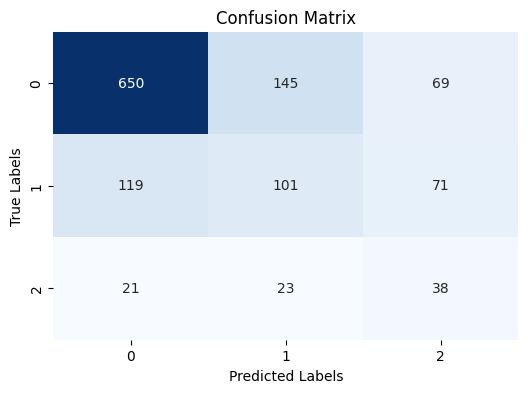


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 650/864 (75.23%)
Class 1: Correct Predictions / Total True Samples = 101/291 (34.71%)
Class 2: Correct Predictions / Total True Samples = 38/82 (46.34%)

Precision-Recall Curves:


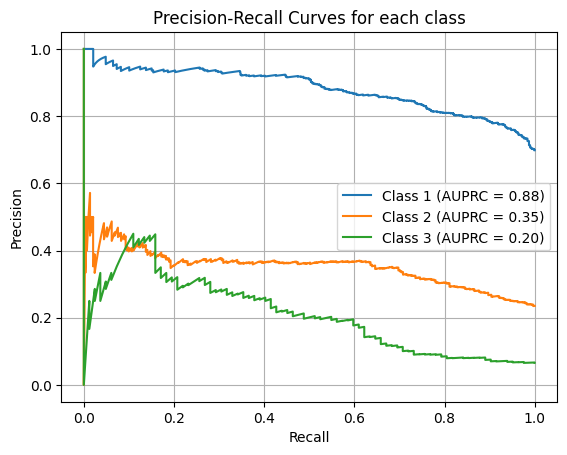


ROC Curves:


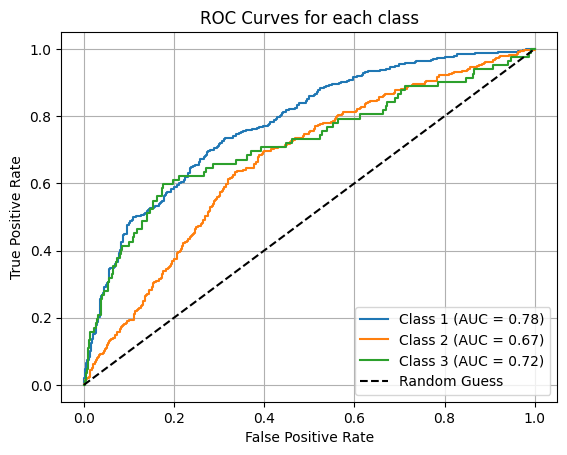


Mean F1 Score: 0.4797
Balanced Accuracy: 0.5209
Average AUPRC: 0.4785

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.75      0.79       864
           1       0.38      0.35      0.36       291
           2       0.21      0.46      0.29        82

    accuracy                           0.64      1237
   macro avg       0.47      0.52      0.48      1237
weighted avg       0.68      0.64      0.65      1237

Fold No: 2
training on folds: [[np.int64(2), np.int64(0), np.int64(3)]]
validation on folds: 1
test on folds: 4
Epoch [1/100], Loss: 1.1034, Accuracy: 0.3707
Validation Loss: 1.1094, Validation Accuracy: 0.4097
Epoch [2/100], Loss: 1.0683, Accuracy: 0.4498
Validation Loss: 1.0944, Validation Accuracy: 0.4863
Epoch [3/100], Loss: 1.0171, Accuracy: 0.5536
Validation Loss: 0.9958, Validation Accuracy: 0.5579
Epoch [4/100], Loss: 0.9915, Accuracy: 0.5782
Validation Loss: 1.0374, Validation Accuracy: 0.5744
Epoch [5/100], L

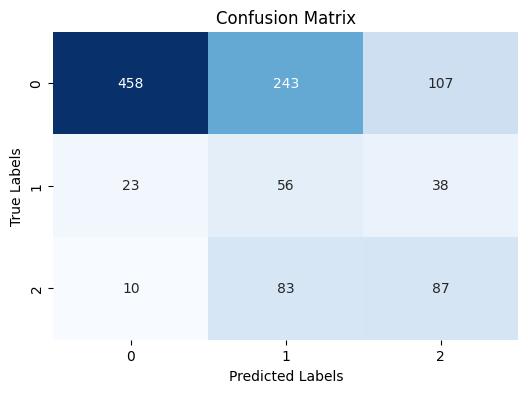


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 458/808 (56.68%)
Class 1: Correct Predictions / Total True Samples = 56/117 (47.86%)
Class 2: Correct Predictions / Total True Samples = 87/180 (48.33%)

Precision-Recall Curves:


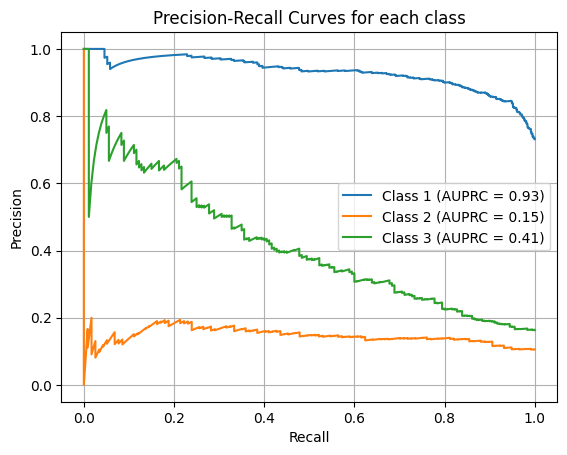


ROC Curves:


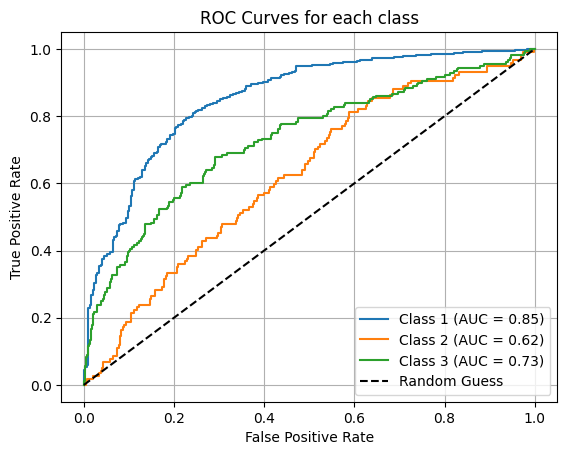


Mean F1 Score: 0.4506
Balanced Accuracy: 0.5096
Average AUPRC: 0.4963

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.57      0.71       808
           1       0.15      0.48      0.22       117
           2       0.38      0.48      0.42       180

    accuracy                           0.54      1105
   macro avg       0.48      0.51      0.45      1105
weighted avg       0.76      0.54      0.61      1105

Fold No: 3
training on folds: [[np.int64(1), np.int64(0), np.int64(3)]]
validation on folds: 4
test on folds: 2
Epoch [1/100], Loss: 1.0982, Accuracy: 0.3668
Validation Loss: 1.1036, Validation Accuracy: 0.4508
Epoch [2/100], Loss: 1.0629, Accuracy: 0.4691
Validation Loss: 1.0598, Validation Accuracy: 0.5146
Epoch [3/100], Loss: 1.0162, Accuracy: 0.5670
Validation Loss: 0.9950, Validation Accuracy: 0.4889
Epoch [4/100], Loss: 0.9952, Accuracy: 0.5996
Validation Loss: 1.0212, Validation Accuracy: 0.5032
Epoch [5/100], L

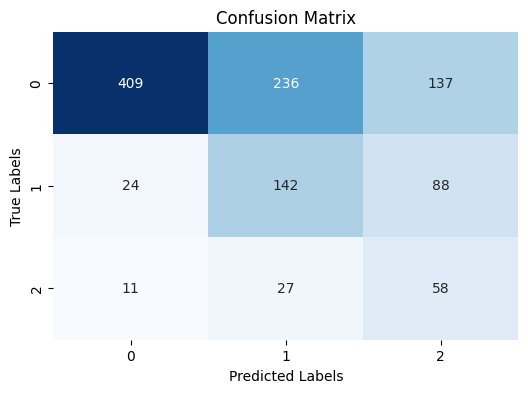


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 409/782 (52.30%)
Class 1: Correct Predictions / Total True Samples = 142/254 (55.91%)
Class 2: Correct Predictions / Total True Samples = 58/96 (60.42%)

Precision-Recall Curves:


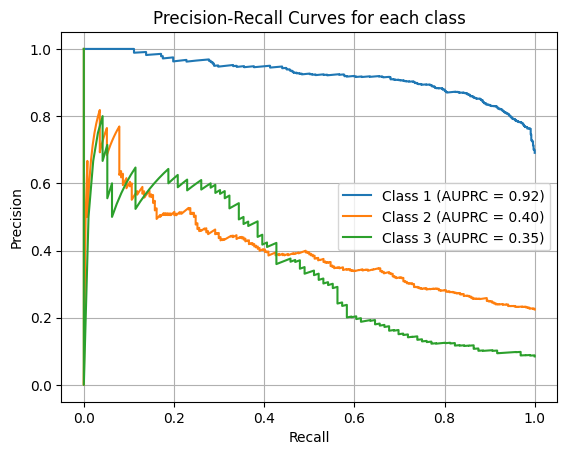


ROC Curves:


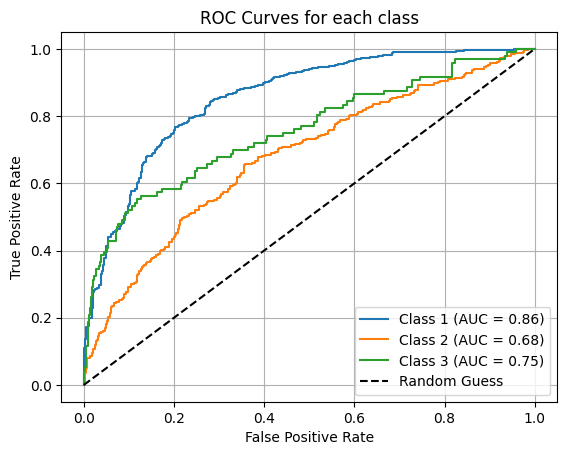


Mean F1 Score: 0.4681
Balanced Accuracy: 0.5621
Average AUPRC: 0.5566

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.52      0.67       782
           1       0.35      0.56      0.43       254
           2       0.20      0.60      0.31        96

    accuracy                           0.54      1132
   macro avg       0.49      0.56      0.47      1132
weighted avg       0.73      0.54      0.58      1132

Fold No: 4
training on folds: [[np.int64(1), np.int64(4), np.int64(3)]]
validation on folds: 2
test on folds: 0
Epoch [1/100], Loss: 1.1008, Accuracy: 0.3980
Validation Loss: 1.1152, Validation Accuracy: 0.4371
Epoch [2/100], Loss: 1.0473, Accuracy: 0.4942
Validation Loss: 1.0787, Validation Accuracy: 0.4487
Epoch [3/100], Loss: 1.0158, Accuracy: 0.5581
Validation Loss: 1.0084, Validation Accuracy: 0.4925
Epoch [4/100], Loss: 0.9899, Accuracy: 0.5989
Validation Loss: 1.0134, Validation Accuracy: 0.5134
Epoch [5/100], L

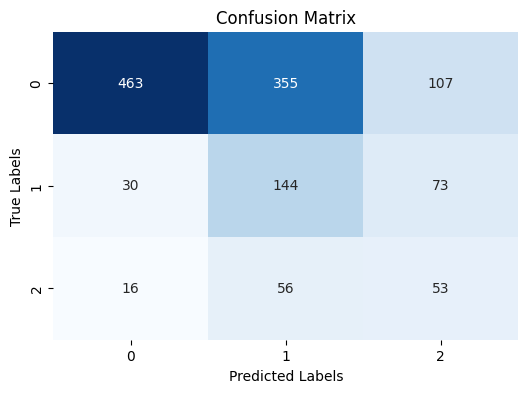


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 463/925 (50.05%)
Class 1: Correct Predictions / Total True Samples = 144/247 (58.30%)
Class 2: Correct Predictions / Total True Samples = 53/125 (42.40%)

Precision-Recall Curves:


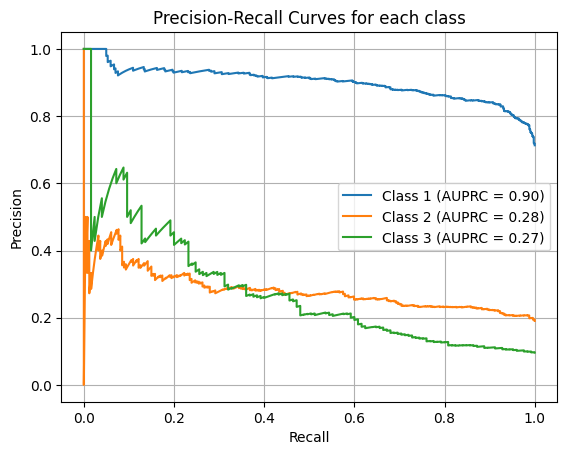


ROC Curves:


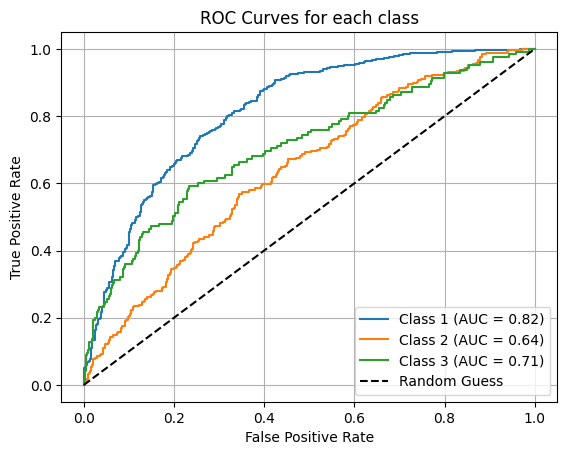


Mean F1 Score: 0.4336
Balanced Accuracy: 0.5025
Average AUPRC: 0.4848

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.50      0.65       925
           1       0.26      0.58      0.36       247
           2       0.23      0.42      0.30       125

    accuracy                           0.51      1297
   macro avg       0.47      0.50      0.43      1297
weighted avg       0.72      0.51      0.56      1297

Fold No: 5
training on folds: [[np.int64(1), np.int64(4), np.int64(2)]]
validation on folds: 0
test on folds: 3
Epoch [1/100], Loss: 1.1032, Accuracy: 0.3566
Validation Loss: 1.0663, Validation Accuracy: 0.3875
Epoch [2/100], Loss: 1.0760, Accuracy: 0.4330
Validation Loss: 1.0690, Validation Accuracy: 0.4494
Epoch [3/100], Loss: 1.0080, Accuracy: 0.5689
Validation Loss: 1.0160, Validation Accuracy: 0.5053
Epoch [4/100], Loss: 0.9911, Accuracy: 0.6071
Validation Loss: 1.0627, Validation Accuracy: 0.4973
Epoch [5/100], L

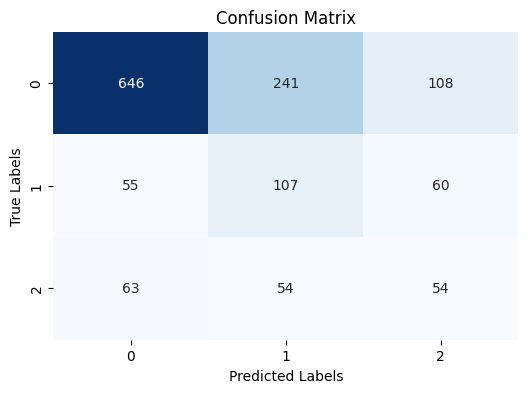


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 646/995 (64.92%)
Class 1: Correct Predictions / Total True Samples = 107/222 (48.20%)
Class 2: Correct Predictions / Total True Samples = 54/171 (31.58%)

Precision-Recall Curves:


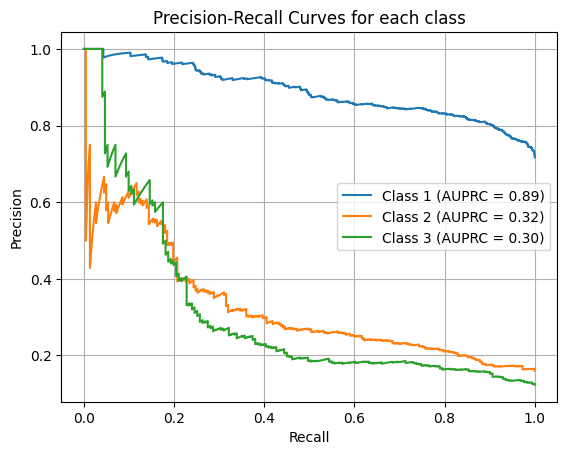


ROC Curves:


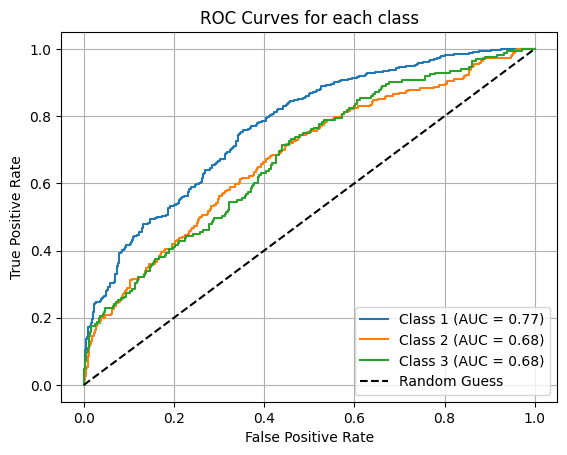


Mean F1 Score: 0.4508
Balanced Accuracy: 0.4823
Average AUPRC: 0.5058

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.65      0.73       995
           1       0.27      0.48      0.34       222
           2       0.24      0.32      0.27       171

    accuracy                           0.58      1388
   macro avg       0.45      0.48      0.45      1388
weighted avg       0.68      0.58      0.62      1388

Accuracy for each fold: [np.float64(0.5209361622539478), np.float64(0.5095991650447096), np.float64(0.5620798958634007), np.float64(0.5025121639858482), np.float64(0.48233922894065717)]
AUPRC for each fold: [np.float64(0.4785165033448524), np.float64(0.4962776092596655), np.float64(0.5565640896521535), np.float64(0.48478919364674367), np.float64(0.5058088657399074)]
Average AUPRC across all folds: 0.5043912523286644
Average Balanced Accuracy across all folds: 0.5154933232177127


In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import balanced_accuracy_score, confusion_matrix
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve, auc




# Training loop for cross-validation
for fold_idx in range(num_folds):
    print(f'Fold No: {fold_idx + 1}')
    
    # Initialize model, loss, and optimizer
    fold_model = TRANS_CNN(input_shape=input_shape,num_classes=num_classes,embed_dim=128,num_heads=num_heads,num_transformer_blocks=num_transformer_blocks) # Initialize your model here
    fold_model.to(device)
    
    criterion = nn.CrossEntropyLoss(label_smoothing=0.3)
    optimizer = optim.AdamW(fold_model.parameters(), lr=learning_rate,weight_decay=weight_decay)
    
    # Split data into train, validation, and test sets
    test_fold = fold_indices[fold_idx]
    val_fold = val_fold_indices[fold_idx]
    train_folds = [fold for fold in fold_indices if fold != test_fold and fold != val_fold]
    
    print(f"training on folds: {[train_folds]}")
    print(f"validation on folds: {val_fold}")
    print(f"test on folds: {test_fold}")
    

    train_data = np.concatenate([eeg_folds[j] for j in train_folds])
    train_labels = np.concatenate([labels_folds[j] for j in train_folds])
    train_data = train_data.transpose(0, 3, 1, 2)  # Transpose to match PyTorch input format

    test_folds_chosen.append(test_fold)
    val_folds_chosen.append(val_fold)
    
    early_stopping = EarlyStopping(patience=10)
    
    # Training loop
    for epoch in range(epochs):
        balanced_train_data, balanced_train_labels = data_balancer(train_data, train_labels, factor=1)

        train_dataset = TensorDataset(
            torch.tensor(balanced_train_data, dtype=torch.float32).to(device),
            torch.tensor(balanced_train_labels, dtype=torch.long).to(device)
        )
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        
        fold_model.train()
        running_loss = 0.0
        all_preds = []
        all_labels = []
        
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = fold_model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = balanced_accuracy_score(all_labels, all_preds)
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')

        # Validation loop
        val_data = eeg_folds[val_fold].transpose(0, 3, 1, 2)
        val_labels = labels_folds[val_fold]
        val_dataset = TensorDataset(
            torch.tensor(val_data, dtype=torch.float32).to(device),
            torch.tensor(val_labels, dtype=torch.long).to(device)
        )
        val_loader = DataLoader(val_dataset, batch_size=10, shuffle=False)

        fold_model.eval()
        val_loss = 0.0
        val_preds = []
        val_labels_list = []

        with torch.no_grad():
            for val_inputs, val_labels in val_loader:
                val_outputs = fold_model(val_inputs)
                loss = criterion(val_outputs, val_labels)
                val_loss += loss.item()

                _, val_batch_preds = torch.max(val_outputs, 1)
                val_preds.extend(val_batch_preds.cpu().numpy())
                val_labels_list.extend(val_labels.cpu().numpy())

        val_loss /= len(val_loader)
        val_acc = balanced_accuracy_score(val_labels_list, val_preds)
        print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')

        early_stopping(val_loss, fold_model)
        if early_stopping.early_stop:
            print("Early stopping")
            break

    # Load the best model
    early_stopping.load_best_model(fold_model)

    # Test loop
    test_data = eeg_folds[test_fold].transpose(0, 3, 1, 2)
    test_labels = labels_folds[test_fold]
    test_dataset = TensorDataset(
        torch.tensor(test_data, dtype=torch.float32).to(device),
        torch.tensor(test_labels, dtype=torch.long).to(device)
    )
    test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

    fold_model.eval()
    test_probs = []
    test_preds = []
    test_labels_list = []

    with torch.no_grad():
        for test_inputs, test_labels in test_loader:
            test_outputs = fold_model(test_inputs)
            probabilities = torch.softmax(test_outputs, dim=1)
            test_probs.extend(probabilities.cpu().numpy())
            _, preds = torch.max(probabilities, 1)
            test_preds.extend(preds.cpu().numpy())
            test_labels_list.extend(test_labels.cpu().numpy())

    # Compute metrics
    test_acc = balanced_accuracy_score(test_labels_list, test_preds)
    fold_accuracies.append(test_acc)

    cm = confusion_matrix(test_labels_list, test_preds)
    fold_confusion_matrices.append(cm)

    test_labels_binarized = label_binarize(test_labels_list, classes=np.arange(num_classes))
    test_auprcs = []
    for class_idx in range(num_classes):
        precision, recall, _ = precision_recall_curve(test_labels_binarized[:, class_idx], np.array(test_probs)[:, class_idx])
        auprc = auc(recall, precision)
        test_auprcs.append(auprc)

    mean_test_auprc = np.mean(test_auprcs)
    fold_auprcs.append(mean_test_auprc)

    print(f'Test Fold {fold_idx + 1}, Mean AUPRC: {mean_test_auprc:.4f}, Balanced Accuracy: {test_acc:.4f}')

    # Use the plot_metrics function to visualize metrics
    plot_metrics(np.array(test_labels_list), np.array(test_probs), n_classes=num_classes)

# Final metrics across all folds
average_auprc = np.mean(fold_auprcs)
mean_accuracy = np.mean(fold_accuracies)
print(f'Accuracy for each fold: {fold_accuracies}')
print(f'AUPRC for each fold: {fold_auprcs}')
print(f'Average AUPRC across all folds: {average_auprc}')
print(f'Average Balanced Accuracy across all folds: {mean_accuracy}')
    


In [24]:
# Save all results to CSV
model_description = f"TRANS_CNN hyper#3 CONCAT_UNFIL MANUAL APPROACH 3 classes"
save_results_to_csv(fold_accuracies, fold_auprcs, fold_confusion_matrices, model_description)

Results saved to D:\PYTHONIG\aprilmay2025\newnotebooks\results.csv


<h1> hyper 4

In [25]:

import pandas as pd
import os
import datetime


torch.random.manual_seed(42)  # For reproducibility
np.random.seed(42)  # For reproducibility

params = {'num_heads': 8, 'num_transformer_blocks': 8, 'learning_rate': 4.65e-05, 'optimizer': 'Adam', 'weight_decay': 4.53e-05, 'batch_size': 10, 'factor': 1}


# Fold indices and other configurations
num_folds = 5
fold_indices = np.random.permutation(np.arange(num_folds))
val_fold_indices = np.roll(fold_indices, 1)

test_folds_chosen = []
val_folds_chosen = []
fold_confusion_matrices = []  # To store confusion matrices for each fold
fold_accuracies = []  # To store balanced accuracy for each fold
fold_auprcs = []  # To store AUPRC for each fold

# Model and training configurations
num_classes = 3
epochs = 100
input_shape = (3,224,224)
embed_dim = 128
num_heads = params['num_heads']
num_transformer_blocks = params['num_transformer_blocks']
learning_rate = params['learning_rate']
optimizer = params['optimizer']
weight_decay = params['weight_decay']
batch_size = params['batch_size']

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



Fold No: 1
training on folds: [[np.int64(4), np.int64(2), np.int64(0)]]
validation on folds: 3
test on folds: 1
Epoch [1/100], Loss: 1.0961, Accuracy: 0.3633
Validation Loss: 1.1574, Validation Accuracy: 0.3487
Epoch [2/100], Loss: 1.0546, Accuracy: 0.4855
Validation Loss: 1.0077, Validation Accuracy: 0.4532
Epoch [3/100], Loss: 1.0049, Accuracy: 0.5694
Validation Loss: 1.0423, Validation Accuracy: 0.4799
Epoch [4/100], Loss: 0.9893, Accuracy: 0.6085
Validation Loss: 1.0192, Validation Accuracy: 0.4866
Epoch [5/100], Loss: 0.9804, Accuracy: 0.6193
Validation Loss: 0.9917, Validation Accuracy: 0.4791
Epoch [6/100], Loss: 0.9696, Accuracy: 0.6367
Validation Loss: 0.9826, Validation Accuracy: 0.4809
Epoch [7/100], Loss: 0.9692, Accuracy: 0.6492
Validation Loss: 0.9846, Validation Accuracy: 0.4859
Epoch [8/100], Loss: 0.9522, Accuracy: 0.6692
Validation Loss: 0.9924, Validation Accuracy: 0.4915
Epoch [9/100], Loss: 0.9482, Accuracy: 0.6833
Validation Loss: 0.9770, Validation Accuracy: 0.48

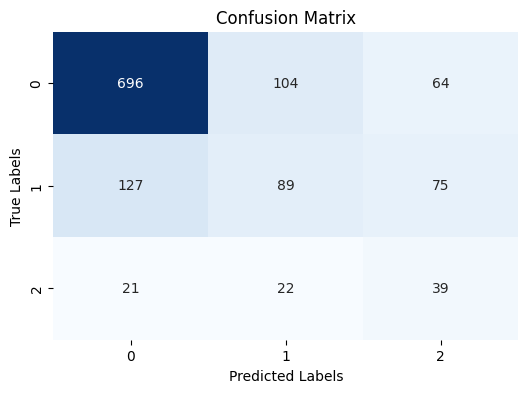


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 696/864 (80.56%)
Class 1: Correct Predictions / Total True Samples = 89/291 (30.58%)
Class 2: Correct Predictions / Total True Samples = 39/82 (47.56%)

Precision-Recall Curves:


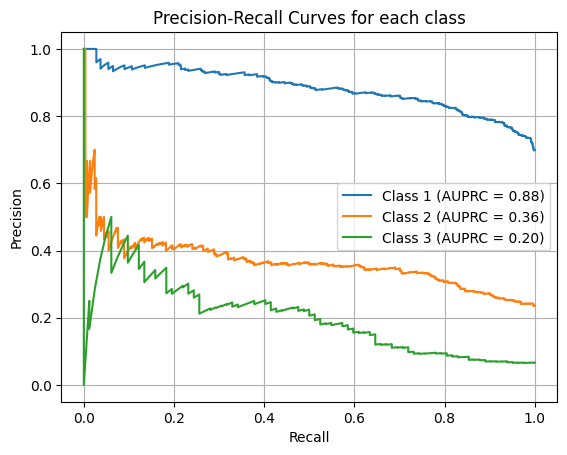


ROC Curves:


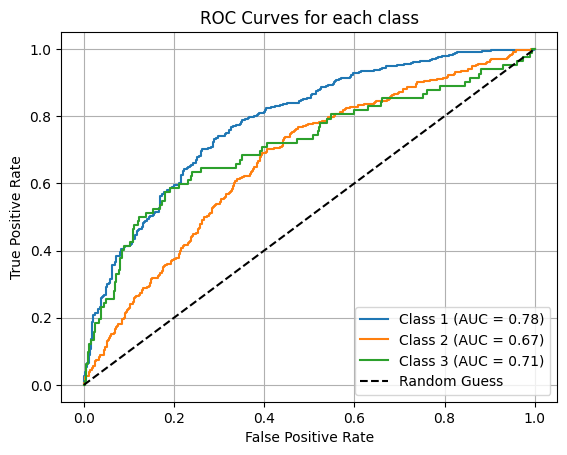


Mean F1 Score: 0.4889
Balanced Accuracy: 0.5290
Average AUPRC: 0.4809

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.81      0.81       864
           1       0.41      0.31      0.35       291
           2       0.22      0.48      0.30        82

    accuracy                           0.67      1237
   macro avg       0.49      0.53      0.49      1237
weighted avg       0.69      0.67      0.67      1237

Fold No: 2
training on folds: [[np.int64(2), np.int64(0), np.int64(3)]]
validation on folds: 1
test on folds: 4
Epoch [1/100], Loss: 1.1039, Accuracy: 0.3588
Validation Loss: 1.1152, Validation Accuracy: 0.3784
Epoch [2/100], Loss: 1.0810, Accuracy: 0.4150
Validation Loss: 1.1004, Validation Accuracy: 0.4667
Epoch [3/100], Loss: 1.0329, Accuracy: 0.5247
Validation Loss: 1.0096, Validation Accuracy: 0.5198
Epoch [4/100], Loss: 1.0047, Accuracy: 0.5536
Validation Loss: 1.0227, Validation Accuracy: 0.5776
Epoch [5/100], L

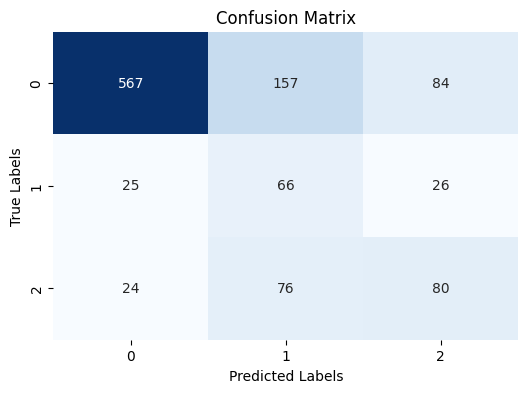


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 567/808 (70.17%)
Class 1: Correct Predictions / Total True Samples = 66/117 (56.41%)
Class 2: Correct Predictions / Total True Samples = 80/180 (44.44%)

Precision-Recall Curves:


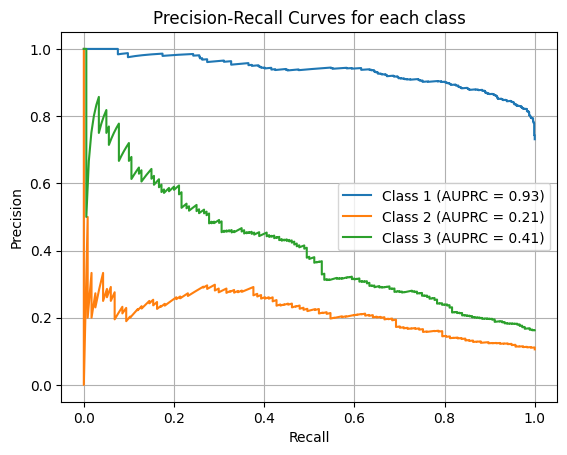


ROC Curves:


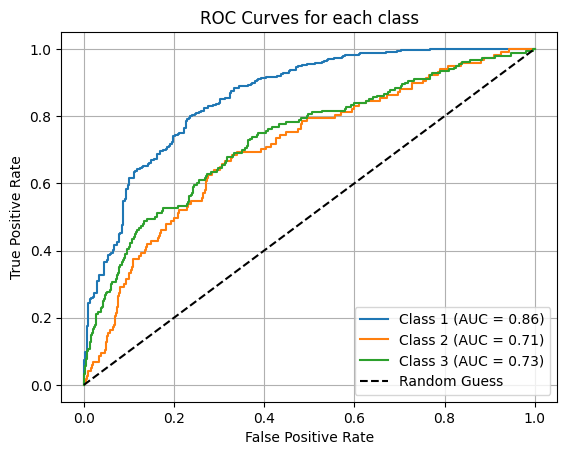


Mean F1 Score: 0.5154
Balanced Accuracy: 0.5701
Average AUPRC: 0.5170

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.70      0.80       808
           1       0.22      0.56      0.32       117
           2       0.42      0.44      0.43       180

    accuracy                           0.65      1105
   macro avg       0.52      0.57      0.52      1105
weighted avg       0.77      0.65      0.69      1105

Fold No: 3
training on folds: [[np.int64(1), np.int64(0), np.int64(3)]]
validation on folds: 4
test on folds: 2
Epoch [1/100], Loss: 1.0982, Accuracy: 0.3695
Validation Loss: 1.0400, Validation Accuracy: 0.3576
Epoch [2/100], Loss: 1.0731, Accuracy: 0.4418
Validation Loss: 1.0968, Validation Accuracy: 0.4186
Epoch [3/100], Loss: 1.0512, Accuracy: 0.4762
Validation Loss: 1.0371, Validation Accuracy: 0.4448
Epoch [4/100], Loss: 1.0191, Accuracy: 0.5776
Validation Loss: 0.9588, Validation Accuracy: 0.4999
Epoch [5/100], L

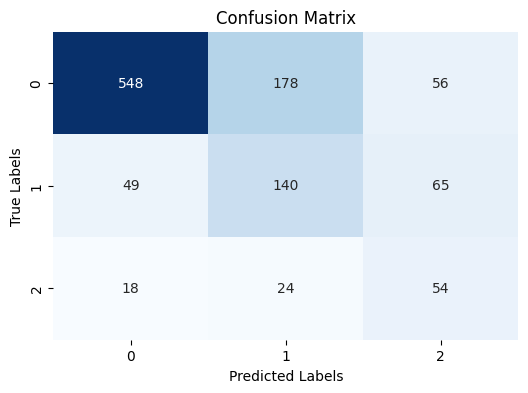


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 548/782 (70.08%)
Class 1: Correct Predictions / Total True Samples = 140/254 (55.12%)
Class 2: Correct Predictions / Total True Samples = 54/96 (56.25%)

Precision-Recall Curves:


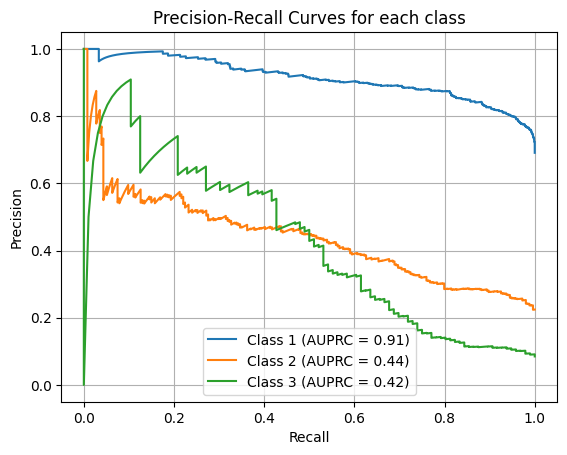


ROC Curves:


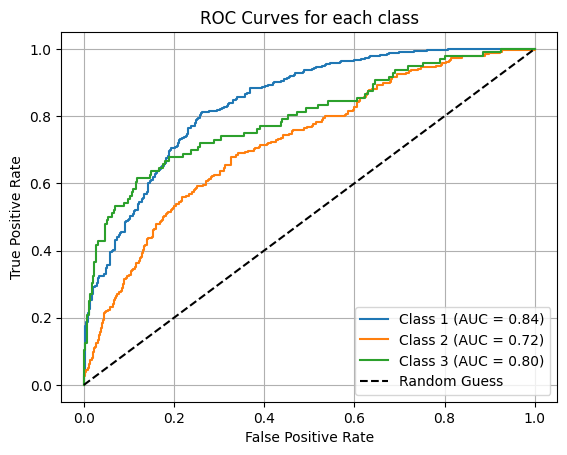


Mean F1 Score: 0.5510
Balanced Accuracy: 0.6048
Average AUPRC: 0.5899

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.70      0.78       782
           1       0.41      0.55      0.47       254
           2       0.31      0.56      0.40        96

    accuracy                           0.66      1132
   macro avg       0.54      0.60      0.55      1132
weighted avg       0.73      0.66      0.68      1132

Fold No: 4
training on folds: [[np.int64(1), np.int64(4), np.int64(3)]]
validation on folds: 2
test on folds: 0
Epoch [1/100], Loss: 1.1045, Accuracy: 0.3426
Validation Loss: 1.0534, Validation Accuracy: 0.3648
Epoch [2/100], Loss: 1.0774, Accuracy: 0.4334
Validation Loss: 1.0363, Validation Accuracy: 0.4749
Epoch [3/100], Loss: 1.0350, Accuracy: 0.5273
Validation Loss: 1.0746, Validation Accuracy: 0.4723
Epoch [4/100], Loss: 1.0135, Accuracy: 0.5566
Validation Loss: 1.0229, Validation Accuracy: 0.5167
Epoch [5/100], L

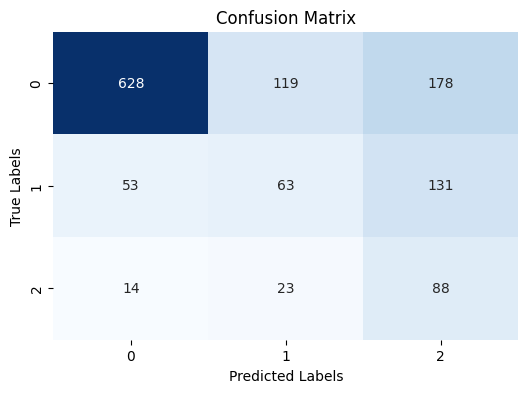


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 628/925 (67.89%)
Class 1: Correct Predictions / Total True Samples = 63/247 (25.51%)
Class 2: Correct Predictions / Total True Samples = 88/125 (70.40%)

Precision-Recall Curves:


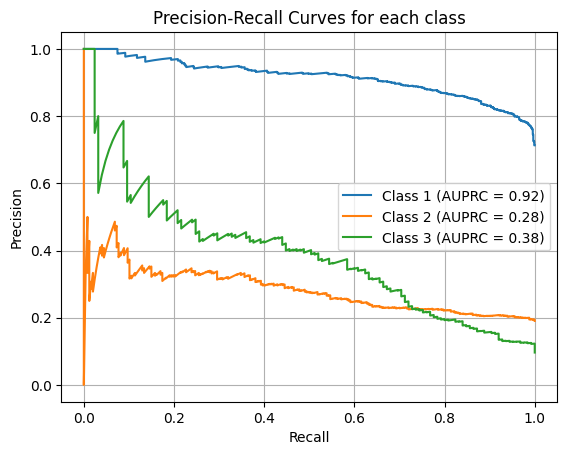


ROC Curves:


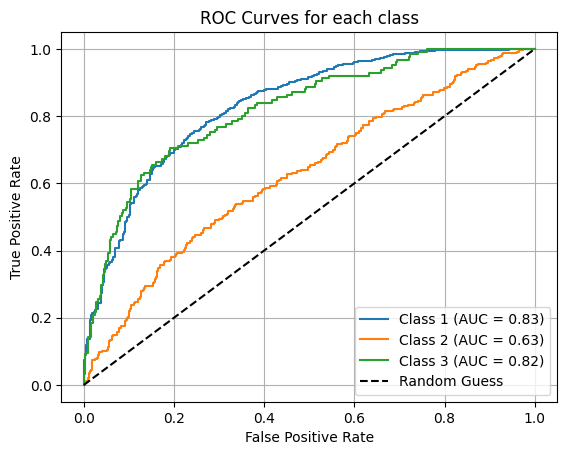


Mean F1 Score: 0.4637
Balanced Accuracy: 0.5460
Average AUPRC: 0.5267

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.68      0.78       925
           1       0.31      0.26      0.28       247
           2       0.22      0.70      0.34       125

    accuracy                           0.60      1297
   macro avg       0.48      0.55      0.46      1297
weighted avg       0.72      0.60      0.64      1297

Fold No: 5
training on folds: [[np.int64(1), np.int64(4), np.int64(2)]]
validation on folds: 0
test on folds: 3
Epoch [1/100], Loss: 1.0956, Accuracy: 0.4041
Validation Loss: 1.0336, Validation Accuracy: 0.4533
Epoch [2/100], Loss: 1.0504, Accuracy: 0.4870
Validation Loss: 1.1178, Validation Accuracy: 0.4720
Epoch [3/100], Loss: 1.0048, Accuracy: 0.5987
Validation Loss: 0.9957, Validation Accuracy: 0.5286
Epoch [4/100], Loss: 0.9919, Accuracy: 0.6071
Validation Loss: 1.0299, Validation Accuracy: 0.5052
Epoch [5/100], L

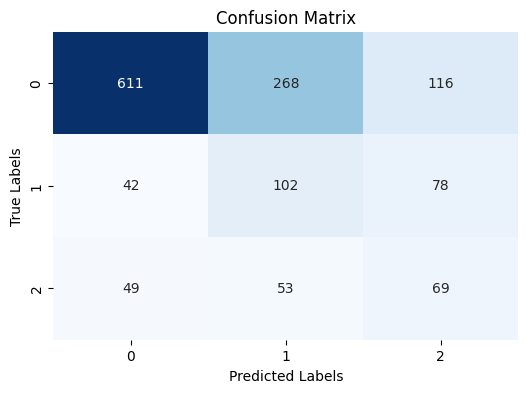


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 611/995 (61.41%)
Class 1: Correct Predictions / Total True Samples = 102/222 (45.95%)
Class 2: Correct Predictions / Total True Samples = 69/171 (40.35%)

Precision-Recall Curves:


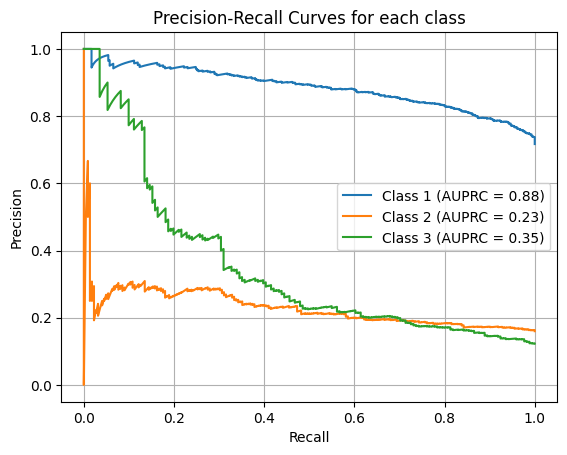


ROC Curves:


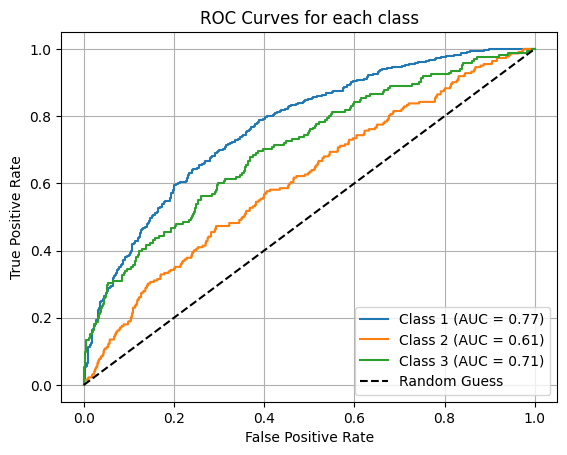


Mean F1 Score: 0.4514
Balanced Accuracy: 0.4923
Average AUPRC: 0.4861

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.61      0.72       995
           1       0.24      0.46      0.32       222
           2       0.26      0.40      0.32       171

    accuracy                           0.56      1388
   macro avg       0.46      0.49      0.45      1388
weighted avg       0.69      0.56      0.61      1388

Accuracy for each fold: [np.float64(0.5290024120172473), np.float64(0.5700932272714451), np.float64(0.6048161219297715), np.float64(0.5459932158879527), np.float64(0.4923461943826926)]
AUPRC for each fold: [np.float64(0.480928599389614), np.float64(0.5170154720172737), np.float64(0.5898642283609155), np.float64(0.5267054334596283), np.float64(0.4860782005644448)]
Average AUPRC across all folds: 0.5201183867583752
Average Balanced Accuracy across all folds: 0.5484502342978218


In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import balanced_accuracy_score, confusion_matrix
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve, auc




# Training loop for cross-validation
for fold_idx in range(num_folds):
    print(f'Fold No: {fold_idx + 1}')
    
    # Initialize model, loss, and optimizer
    fold_model = TRANS_CNN(input_shape=input_shape,num_classes=num_classes,embed_dim=128,num_heads=num_heads,num_transformer_blocks=num_transformer_blocks) # Initialize your model here
    fold_model.to(device)
    
    criterion = nn.CrossEntropyLoss(label_smoothing=0.3)
    optimizer = optim.AdamW(fold_model.parameters(), lr=learning_rate,weight_decay=weight_decay)
    
    # Split data into train, validation, and test sets
    test_fold = fold_indices[fold_idx]
    val_fold = val_fold_indices[fold_idx]
    train_folds = [fold for fold in fold_indices if fold != test_fold and fold != val_fold]
    
    print(f"training on folds: {[train_folds]}")
    print(f"validation on folds: {val_fold}")
    print(f"test on folds: {test_fold}")
    

    train_data = np.concatenate([eeg_folds[j] for j in train_folds])
    train_labels = np.concatenate([labels_folds[j] for j in train_folds])
    train_data = train_data.transpose(0, 3, 1, 2)  # Transpose to match PyTorch input format

    test_folds_chosen.append(test_fold)
    val_folds_chosen.append(val_fold)
    
    early_stopping = EarlyStopping(patience=10)
    
    # Training loop
    for epoch in range(epochs):
        balanced_train_data, balanced_train_labels = data_balancer(train_data, train_labels, factor=1)

        train_dataset = TensorDataset(
            torch.tensor(balanced_train_data, dtype=torch.float32).to(device),
            torch.tensor(balanced_train_labels, dtype=torch.long).to(device)
        )
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        
        fold_model.train()
        running_loss = 0.0
        all_preds = []
        all_labels = []
        
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = fold_model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = balanced_accuracy_score(all_labels, all_preds)
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')

        # Validation loop
        val_data = eeg_folds[val_fold].transpose(0, 3, 1, 2)
        val_labels = labels_folds[val_fold]
        val_dataset = TensorDataset(
            torch.tensor(val_data, dtype=torch.float32).to(device),
            torch.tensor(val_labels, dtype=torch.long).to(device)
        )
        val_loader = DataLoader(val_dataset, batch_size=10, shuffle=False)

        fold_model.eval()
        val_loss = 0.0
        val_preds = []
        val_labels_list = []

        with torch.no_grad():
            for val_inputs, val_labels in val_loader:
                val_outputs = fold_model(val_inputs)
                loss = criterion(val_outputs, val_labels)
                val_loss += loss.item()

                _, val_batch_preds = torch.max(val_outputs, 1)
                val_preds.extend(val_batch_preds.cpu().numpy())
                val_labels_list.extend(val_labels.cpu().numpy())

        val_loss /= len(val_loader)
        val_acc = balanced_accuracy_score(val_labels_list, val_preds)
        print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')

        early_stopping(val_loss, fold_model)
        if early_stopping.early_stop:
            print("Early stopping")
            break

    # Load the best model
    early_stopping.load_best_model(fold_model)

    # Test loop
    test_data = eeg_folds[test_fold].transpose(0, 3, 1, 2)
    test_labels = labels_folds[test_fold]
    test_dataset = TensorDataset(
        torch.tensor(test_data, dtype=torch.float32).to(device),
        torch.tensor(test_labels, dtype=torch.long).to(device)
    )
    test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

    fold_model.eval()
    test_probs = []
    test_preds = []
    test_labels_list = []

    with torch.no_grad():
        for test_inputs, test_labels in test_loader:
            test_outputs = fold_model(test_inputs)
            probabilities = torch.softmax(test_outputs, dim=1)
            test_probs.extend(probabilities.cpu().numpy())
            _, preds = torch.max(probabilities, 1)
            test_preds.extend(preds.cpu().numpy())
            test_labels_list.extend(test_labels.cpu().numpy())

    # Compute metrics
    test_acc = balanced_accuracy_score(test_labels_list, test_preds)
    fold_accuracies.append(test_acc)

    cm = confusion_matrix(test_labels_list, test_preds)
    fold_confusion_matrices.append(cm)

    test_labels_binarized = label_binarize(test_labels_list, classes=np.arange(num_classes))
    test_auprcs = []
    for class_idx in range(num_classes):
        precision, recall, _ = precision_recall_curve(test_labels_binarized[:, class_idx], np.array(test_probs)[:, class_idx])
        auprc = auc(recall, precision)
        test_auprcs.append(auprc)

    mean_test_auprc = np.mean(test_auprcs)
    fold_auprcs.append(mean_test_auprc)

    print(f'Test Fold {fold_idx + 1}, Mean AUPRC: {mean_test_auprc:.4f}, Balanced Accuracy: {test_acc:.4f}')

    # Use the plot_metrics function to visualize metrics
    plot_metrics(np.array(test_labels_list), np.array(test_probs), n_classes=num_classes)

# Final metrics across all folds
average_auprc = np.mean(fold_auprcs)
mean_accuracy = np.mean(fold_accuracies)
print(f'Accuracy for each fold: {fold_accuracies}')
print(f'AUPRC for each fold: {fold_auprcs}')
print(f'Average AUPRC across all folds: {average_auprc}')
print(f'Average Balanced Accuracy across all folds: {mean_accuracy}')
    


In [27]:
# Save all results to CSV
model_description = f"TRANS_CNN hyper#4 CONCAT_UNFIL MANUAL APPROACH 3 classes"
save_results_to_csv(fold_accuracies, fold_auprcs, fold_confusion_matrices, model_description)

Results saved to D:\PYTHONIG\aprilmay2025\newnotebooks\results.csv


<h1> hyper 5

In [28]:

import pandas as pd
import os
import datetime

torch.cuda.empty_cache()

torch.random.manual_seed(42)  # For reproducibility
np.random.seed(42)  # For reproducibility

params = {'num_heads': 8, 'num_transformer_blocks': 8, 'learning_rate': 4.68e-05, 'optimizer': 'Adam', 'weight_decay': 4.70e-05, 'batch_size': 10, 'factor': 1}


# Fold indices and other configurations
num_folds = 5
fold_indices = np.random.permutation(np.arange(num_folds))
val_fold_indices = np.roll(fold_indices, 1)

test_folds_chosen = []
val_folds_chosen = []
fold_confusion_matrices = []  # To store confusion matrices for each fold
fold_accuracies = []  # To store balanced accuracy for each fold
fold_auprcs = []  # To store AUPRC for each fold

# Model and training configurations
num_classes = 3
epochs = 100
input_shape = (3,224,224)
embed_dim = 128
num_heads = params['num_heads']
num_transformer_blocks = params['num_transformer_blocks']
learning_rate = params['learning_rate']
optimizer = params['optimizer']
weight_decay = params['weight_decay']
batch_size = params['batch_size']

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



Fold No: 1
training on folds: [[np.int64(4), np.int64(2), np.int64(0)]]
validation on folds: 3
test on folds: 1
Epoch [1/100], Loss: 1.0960, Accuracy: 0.3624
Validation Loss: 1.1571, Validation Accuracy: 0.3490
Epoch [2/100], Loss: 1.0542, Accuracy: 0.4855
Validation Loss: 1.0079, Validation Accuracy: 0.4562
Epoch [3/100], Loss: 1.0046, Accuracy: 0.5702
Validation Loss: 1.0426, Validation Accuracy: 0.4814
Epoch [4/100], Loss: 0.9891, Accuracy: 0.6085
Validation Loss: 1.0192, Validation Accuracy: 0.4851
Epoch [5/100], Loss: 0.9802, Accuracy: 0.6193
Validation Loss: 0.9917, Validation Accuracy: 0.4791
Epoch [6/100], Loss: 0.9693, Accuracy: 0.6359
Validation Loss: 0.9824, Validation Accuracy: 0.4809
Epoch [7/100], Loss: 0.9689, Accuracy: 0.6484
Validation Loss: 0.9847, Validation Accuracy: 0.4879
Epoch [8/100], Loss: 0.9517, Accuracy: 0.6683
Validation Loss: 0.9925, Validation Accuracy: 0.4908
Epoch [9/100], Loss: 0.9479, Accuracy: 0.6841
Validation Loss: 0.9769, Validation Accuracy: 0.48

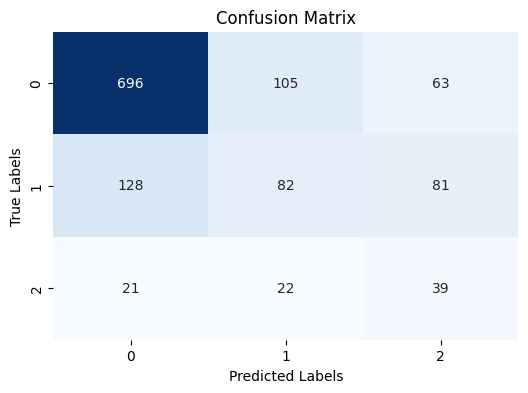


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 696/864 (80.56%)
Class 1: Correct Predictions / Total True Samples = 82/291 (28.18%)
Class 2: Correct Predictions / Total True Samples = 39/82 (47.56%)

Precision-Recall Curves:


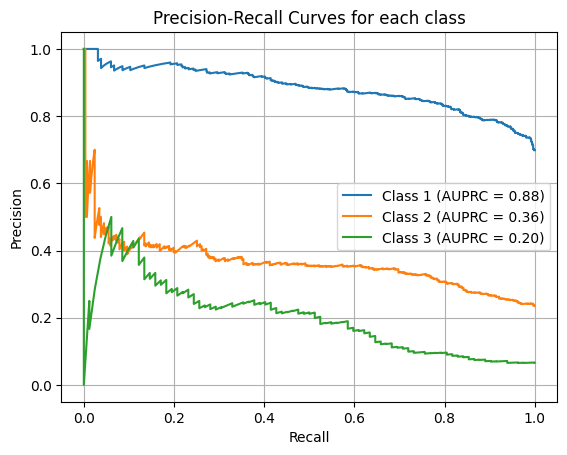


ROC Curves:


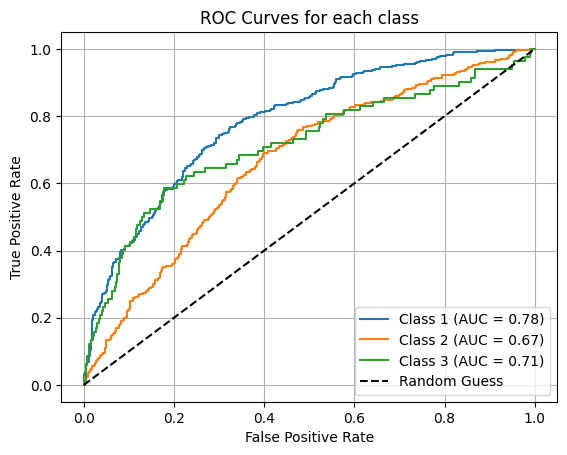


Mean F1 Score: 0.4790
Balanced Accuracy: 0.5210
Average AUPRC: 0.4804

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.81      0.81       864
           1       0.39      0.28      0.33       291
           2       0.21      0.48      0.29        82

    accuracy                           0.66      1237
   macro avg       0.48      0.52      0.48      1237
weighted avg       0.68      0.66      0.67      1237

Fold No: 2
training on folds: [[np.int64(2), np.int64(0), np.int64(3)]]
validation on folds: 1
test on folds: 4
Epoch [1/100], Loss: 1.1039, Accuracy: 0.3597
Validation Loss: 1.1154, Validation Accuracy: 0.3776
Epoch [2/100], Loss: 1.0807, Accuracy: 0.4158
Validation Loss: 1.0995, Validation Accuracy: 0.4638
Epoch [3/100], Loss: 1.0324, Accuracy: 0.5238
Validation Loss: 1.0094, Validation Accuracy: 0.5194
Epoch [4/100], Loss: 1.0044, Accuracy: 0.5544
Validation Loss: 1.0230, Validation Accuracy: 0.5792
Epoch [5/100], L

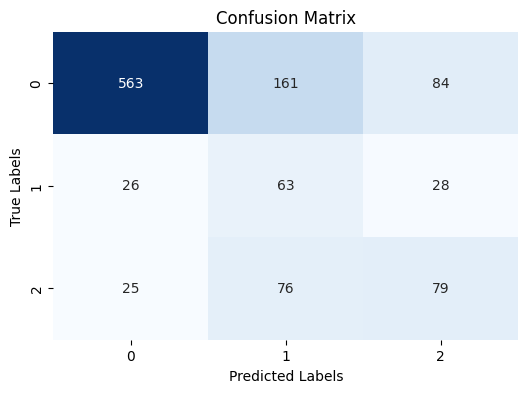


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 563/808 (69.68%)
Class 1: Correct Predictions / Total True Samples = 63/117 (53.85%)
Class 2: Correct Predictions / Total True Samples = 79/180 (43.89%)

Precision-Recall Curves:


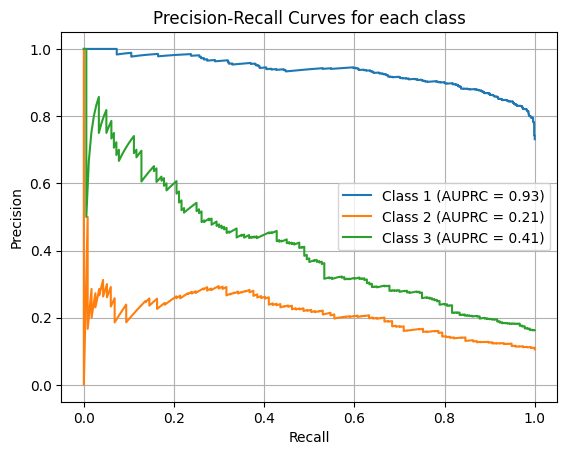


ROC Curves:


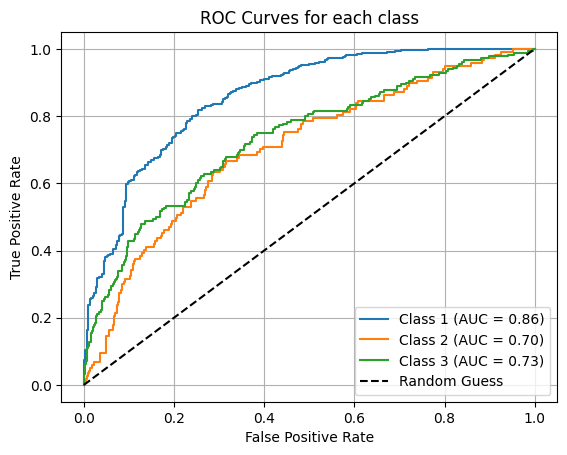


Mean F1 Score: 0.5066
Balanced Accuracy: 0.5580
Average AUPRC: 0.5168

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.70      0.79       808
           1       0.21      0.54      0.30       117
           2       0.41      0.44      0.43       180

    accuracy                           0.64      1105
   macro avg       0.51      0.56      0.51      1105
weighted avg       0.76      0.64      0.68      1105

Fold No: 3
training on folds: [[np.int64(1), np.int64(0), np.int64(3)]]
validation on folds: 4
test on folds: 2
Epoch [1/100], Loss: 1.0982, Accuracy: 0.3704
Validation Loss: 1.0398, Validation Accuracy: 0.3572
Epoch [2/100], Loss: 1.0729, Accuracy: 0.4418
Validation Loss: 1.0964, Validation Accuracy: 0.4186
Epoch [3/100], Loss: 1.0508, Accuracy: 0.4771
Validation Loss: 1.0362, Validation Accuracy: 0.4452
Epoch [4/100], Loss: 1.0185, Accuracy: 0.5794
Validation Loss: 0.9586, Validation Accuracy: 0.4990
Epoch [5/100], L

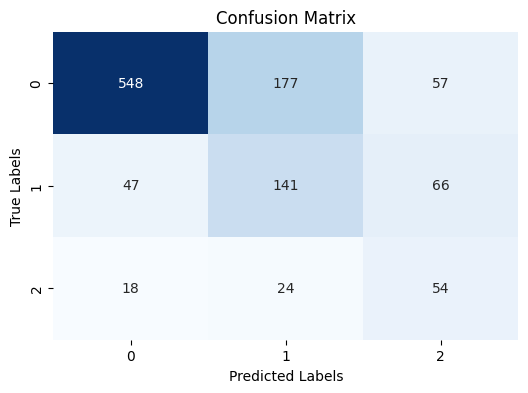


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 548/782 (70.08%)
Class 1: Correct Predictions / Total True Samples = 141/254 (55.51%)
Class 2: Correct Predictions / Total True Samples = 54/96 (56.25%)

Precision-Recall Curves:


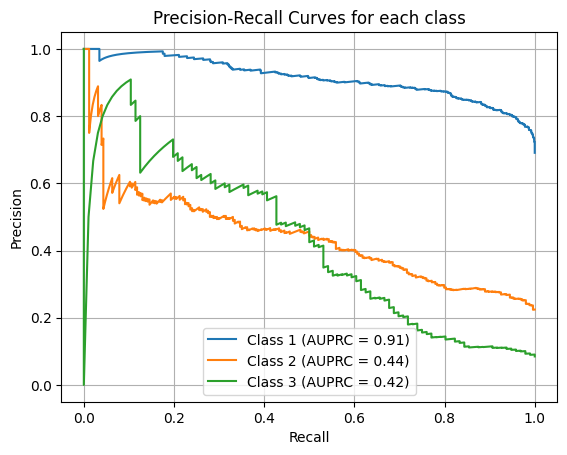


ROC Curves:


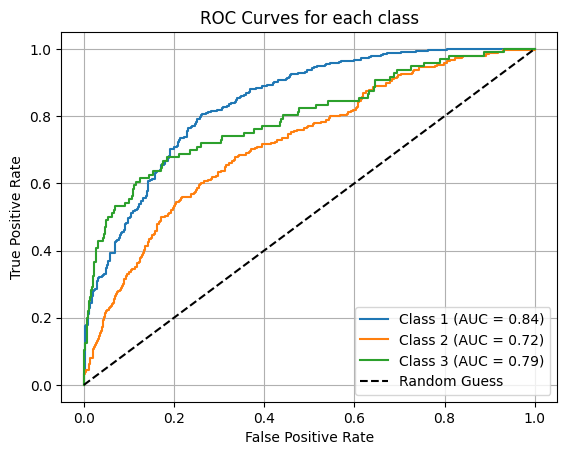


Mean F1 Score: 0.5515
Balanced Accuracy: 0.6061
Average AUPRC: 0.5905

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.70      0.79       782
           1       0.41      0.56      0.47       254
           2       0.31      0.56      0.40        96

    accuracy                           0.66      1132
   macro avg       0.54      0.61      0.55      1132
weighted avg       0.74      0.66      0.68      1132

Fold No: 4
training on folds: [[np.int64(1), np.int64(4), np.int64(3)]]
validation on folds: 2
test on folds: 0
Epoch [1/100], Loss: 1.1045, Accuracy: 0.3410
Validation Loss: 1.0530, Validation Accuracy: 0.3648
Epoch [2/100], Loss: 1.0771, Accuracy: 0.4326
Validation Loss: 1.0353, Validation Accuracy: 0.4757
Epoch [3/100], Loss: 1.0347, Accuracy: 0.5281
Validation Loss: 1.0744, Validation Accuracy: 0.4706
Epoch [4/100], Loss: 1.0132, Accuracy: 0.5581
Validation Loss: 1.0226, Validation Accuracy: 0.5172
Epoch [5/100], L

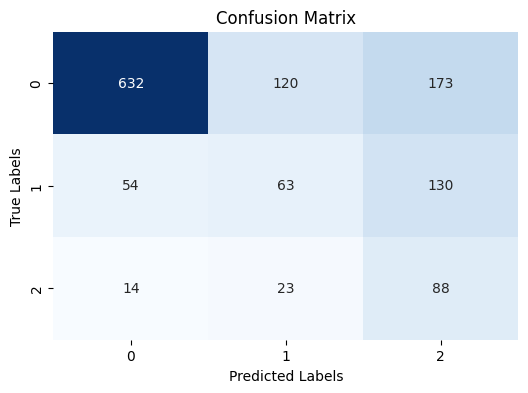


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 632/925 (68.32%)
Class 1: Correct Predictions / Total True Samples = 63/247 (25.51%)
Class 2: Correct Predictions / Total True Samples = 88/125 (70.40%)

Precision-Recall Curves:


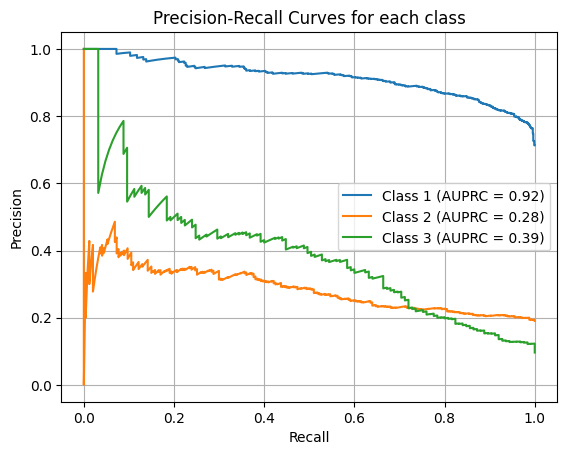


ROC Curves:


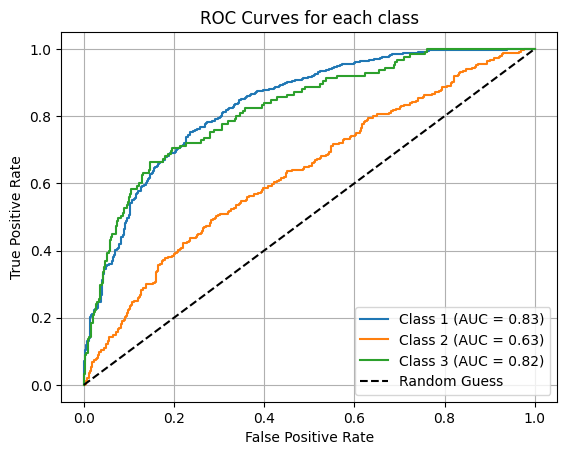


Mean F1 Score: 0.4657
Balanced Accuracy: 0.5474
Average AUPRC: 0.5292

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.68      0.78       925
           1       0.31      0.26      0.28       247
           2       0.23      0.70      0.34       125

    accuracy                           0.60      1297
   macro avg       0.48      0.55      0.47      1297
weighted avg       0.72      0.60      0.64      1297

Fold No: 5
training on folds: [[np.int64(1), np.int64(4), np.int64(2)]]
validation on folds: 0
test on folds: 3
Epoch [1/100], Loss: 1.0955, Accuracy: 0.4050
Validation Loss: 1.0336, Validation Accuracy: 0.4552
Epoch [2/100], Loss: 1.0498, Accuracy: 0.4860
Validation Loss: 1.1169, Validation Accuracy: 0.4717
Epoch [3/100], Loss: 1.0045, Accuracy: 0.6015
Validation Loss: 0.9955, Validation Accuracy: 0.5286
Epoch [4/100], Loss: 0.9917, Accuracy: 0.6071
Validation Loss: 1.0299, Validation Accuracy: 0.5056
Epoch [5/100], L

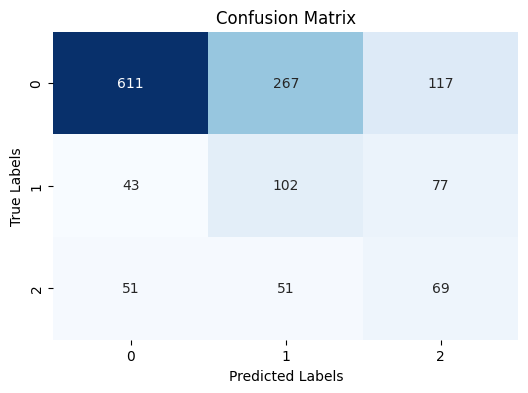


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 611/995 (61.41%)
Class 1: Correct Predictions / Total True Samples = 102/222 (45.95%)
Class 2: Correct Predictions / Total True Samples = 69/171 (40.35%)

Precision-Recall Curves:


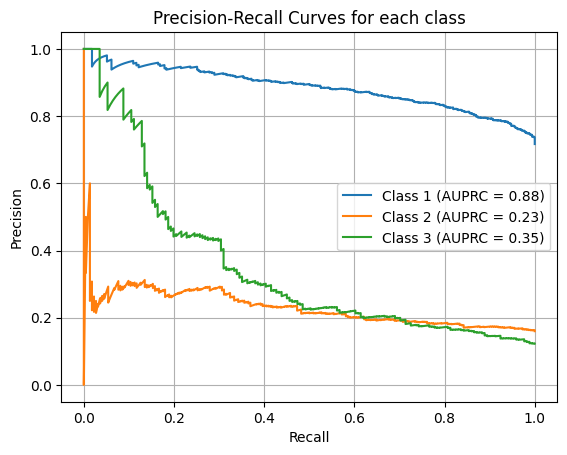


ROC Curves:


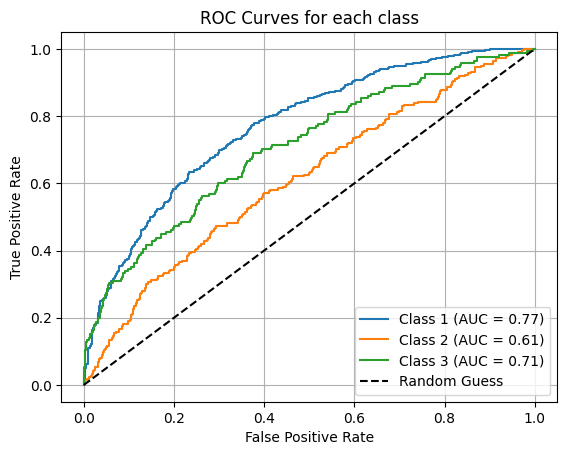


Mean F1 Score: 0.4515
Balanced Accuracy: 0.4923
Average AUPRC: 0.4859

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.61      0.72       995
           1       0.24      0.46      0.32       222
           2       0.26      0.40      0.32       171

    accuracy                           0.56      1388
   macro avg       0.46      0.49      0.45      1388
weighted avg       0.69      0.56      0.61      1388

Accuracy for each fold: [np.float64(0.5209840844112908), np.float64(0.558044201856083), np.float64(0.6061284578877768), np.float64(0.5474346573293941), np.float64(0.4923461943826926)]
AUPRC for each fold: [np.float64(0.4804442068190287), np.float64(0.5167687314193802), np.float64(0.5905076342291081), np.float64(0.5291775122407611), np.float64(0.4858687330865781)]
Average AUPRC across all folds: 0.5205533635589712
Average Balanced Accuracy across all folds: 0.5449875191734475


In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import balanced_accuracy_score, confusion_matrix
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve, auc




# Training loop for cross-validation
for fold_idx in range(num_folds):
    print(f'Fold No: {fold_idx + 1}')
    
    # Initialize model, loss, and optimizer
    fold_model = TRANS_CNN(input_shape=input_shape,num_classes=num_classes,embed_dim=128,num_heads=num_heads,num_transformer_blocks=num_transformer_blocks) # Initialize your model here
    fold_model.to(device)
    
    criterion = nn.CrossEntropyLoss(label_smoothing=0.3)
    optimizer = optim.AdamW(fold_model.parameters(), lr=learning_rate,weight_decay=weight_decay)
    
    # Split data into train, validation, and test sets
    test_fold = fold_indices[fold_idx]
    val_fold = val_fold_indices[fold_idx]
    train_folds = [fold for fold in fold_indices if fold != test_fold and fold != val_fold]
    
    print(f"training on folds: {[train_folds]}")
    print(f"validation on folds: {val_fold}")
    print(f"test on folds: {test_fold}")
    

    train_data = np.concatenate([eeg_folds[j] for j in train_folds])
    train_labels = np.concatenate([labels_folds[j] for j in train_folds])
    train_data = train_data.transpose(0, 3, 1, 2)  # Transpose to match PyTorch input format

    test_folds_chosen.append(test_fold)
    val_folds_chosen.append(val_fold)
    
    early_stopping = EarlyStopping(patience=10)
    
    # Training loop
    for epoch in range(epochs):
        balanced_train_data, balanced_train_labels = data_balancer(train_data, train_labels, factor=1)

        train_dataset = TensorDataset(
            torch.tensor(balanced_train_data, dtype=torch.float32).to(device),
            torch.tensor(balanced_train_labels, dtype=torch.long).to(device)
        )
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        
        fold_model.train()
        running_loss = 0.0
        all_preds = []
        all_labels = []
        
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = fold_model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = balanced_accuracy_score(all_labels, all_preds)
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')

        # Validation loop
        val_data = eeg_folds[val_fold].transpose(0, 3, 1, 2)
        val_labels = labels_folds[val_fold]
        val_dataset = TensorDataset(
            torch.tensor(val_data, dtype=torch.float32).to(device),
            torch.tensor(val_labels, dtype=torch.long).to(device)
        )
        val_loader = DataLoader(val_dataset, batch_size=10, shuffle=False)

        fold_model.eval()
        val_loss = 0.0
        val_preds = []
        val_labels_list = []

        with torch.no_grad():
            for val_inputs, val_labels in val_loader:
                val_outputs = fold_model(val_inputs)
                loss = criterion(val_outputs, val_labels)
                val_loss += loss.item()

                _, val_batch_preds = torch.max(val_outputs, 1)
                val_preds.extend(val_batch_preds.cpu().numpy())
                val_labels_list.extend(val_labels.cpu().numpy())

        val_loss /= len(val_loader)
        val_acc = balanced_accuracy_score(val_labels_list, val_preds)
        print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')

        early_stopping(val_loss, fold_model)
        if early_stopping.early_stop:
            print("Early stopping")
            break

    # Load the best model
    early_stopping.load_best_model(fold_model)

    # Test loop
    test_data = eeg_folds[test_fold].transpose(0, 3, 1, 2)
    test_labels = labels_folds[test_fold]
    test_dataset = TensorDataset(
        torch.tensor(test_data, dtype=torch.float32).to(device),
        torch.tensor(test_labels, dtype=torch.long).to(device)
    )
    test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

    fold_model.eval()
    test_probs = []
    test_preds = []
    test_labels_list = []

    with torch.no_grad():
        for test_inputs, test_labels in test_loader:
            test_outputs = fold_model(test_inputs)
            probabilities = torch.softmax(test_outputs, dim=1)
            test_probs.extend(probabilities.cpu().numpy())
            _, preds = torch.max(probabilities, 1)
            test_preds.extend(preds.cpu().numpy())
            test_labels_list.extend(test_labels.cpu().numpy())

    # Compute metrics
    test_acc = balanced_accuracy_score(test_labels_list, test_preds)
    fold_accuracies.append(test_acc)

    cm = confusion_matrix(test_labels_list, test_preds)
    fold_confusion_matrices.append(cm)

    test_labels_binarized = label_binarize(test_labels_list, classes=np.arange(num_classes))
    test_auprcs = []
    for class_idx in range(num_classes):
        precision, recall, _ = precision_recall_curve(test_labels_binarized[:, class_idx], np.array(test_probs)[:, class_idx])
        auprc = auc(recall, precision)
        test_auprcs.append(auprc)

    mean_test_auprc = np.mean(test_auprcs)
    fold_auprcs.append(mean_test_auprc)

    print(f'Test Fold {fold_idx + 1}, Mean AUPRC: {mean_test_auprc:.4f}, Balanced Accuracy: {test_acc:.4f}')

    # Use the plot_metrics function to visualize metrics
    plot_metrics(np.array(test_labels_list), np.array(test_probs), n_classes=num_classes)

# Final metrics across all folds
average_auprc = np.mean(fold_auprcs)
mean_accuracy = np.mean(fold_accuracies)
print(f'Accuracy for each fold: {fold_accuracies}')
print(f'AUPRC for each fold: {fold_auprcs}')
print(f'Average AUPRC across all folds: {average_auprc}')
print(f'Average Balanced Accuracy across all folds: {mean_accuracy}')
    


In [ ]:
# Save all results to CSV
model_description = f"TRANS_CNN hyper#5 CONCAT_UNFIL MANUAL APPROACH 3 classes"
save_results_to_csv(fold_accuracies, fold_auprcs, fold_confusion_matrices, model_description)

Results saved to D:\PYTHONIG\aprilmay2025\newnotebooks\results.csv


: 